# Imports

In [ ]:
import os
import sqlite3

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pandas as pd
import pycountry
import seaborn as sns

from Final_code._0_Constants.viz_constants import QUERY_ALL_2, QUERY_CONVERSATIONS, DTYPES_2, COMPANY_NAME_TO_ID, COMPANY_ID_TO_NAME, COMPANY_ID_LIST, COMPANY_NAME_LIST
from Final_code._0_Constants.viz_helpers import get_full_language_name, get_country_name
from Final_code._0_Constants.defined_paths import path_local_database

# Loading

In [6]:
# I'm leaving those here for now, later we can move them to _0_Constants\viz_fetching_data_from_db.py and merge into one function that will be able to choose between sqlite and mysql (like it's done for EDA_1)

def get_tweets_with_users(query: str, path: str) -> pd.DataFrame:
    with sqlite3.connect(path) as connection:
        return pd.read_sql_query(query, connection,
                                 dtype=DTYPES_2,
                                 parse_dates=["tweet_creation_time", "user_creation_time"],
                                 index_col='tweet_id')


def get_conversations(query: str, path: str) -> pd.DataFrame:
    with sqlite3.connect(path) as connection:
        return pd.read_sql_query(query, connection,
                                 dtype={"conversation_id": "object", "tweet_order": "int16", "tweet_id": "object"},
                                 index_col=["conversation_id", "tweet_order"])

def get_categories(query: str, path: str): -> pd.DataFrame:
    with sqlite3.connect(path) as connection:
        return pd.read_sql_query(query, connection)

In [53]:
# Later the path will be replaced by the path_local_database variable imported from _0_Constants\defined_paths.py

path =  os.path.join((   
        os.path.dirname(
            os.getcwd()
        )),
    "data_processed", "local_backup.db")
df_tweets_and_users = get_tweets_with_users(QUERY_ALL_2, path)
df_conversations = get_conversations(QUERY_CONVERSATIONS, path)
df_categories = get_categories("SELECT * from ConversationsCategory WHERE category IS NOT 'No Category'", path)

KeyboardInterrupt: 

In [156]:
df_all = df_conversations.merge(df_tweets_and_users, left_on='tweet_id', right_index=True, how='left')
df_all

tweet_id             user_id  \
conversation_id tweet_order                                            
1               1            1244694453190897664           521835883   
                2            1244696682979303426            20626359   
2               1            1244677304598609923           396021583   
                2            1244696641401163776  832964639436701696   
3               1            1244644204132909060           274980475   
...                                          ...                 ...   
493694          3             452657442057646080          2198564846   
493695          1             451124070730719233           701977520   
                2             451125255294443521            22536055   
493696          1             430790355962052608            64327804   
                2             430792524043931648            22536055   

                                   user_creation_time  \
conversation_id tweet_order                             
1               1           2012-03-12 01:11:22+00:00   
                2           2009-02-11 20:50:56+00:00   
2               1           2011-10-22 16:35:05+00:00   
                2           2017-02-18 14:47:00+00:00   
3               1           2011-03-31 11:55:53+00:00   
...                                               ...   
493694          3           2013-11-16 23:24:47+00:00   
493695          1           2012-07-17 23:34:18+00:00   
                2           2009-03-02 21:23:05+00:00   
493696          1           2009-08-10 03:34:27+00:00   
                2           2009-03-02 21:23:05+00:00   

                                  tweet_creation_time  \
conversation_id tweet_order                             
1               1           2020-03-30 18:34:17+00:00   
                2           2020-03-30 18:43:09+00:00   
2               1           2020-03-30 17:26:09+00:00   
                2           2020-03-30 18:42:59+00:00   
3               1           2020-03-30 15:14:37+00:00   
...                                               ...   
493694          3           2014-04-06 04:01:58+00:00   
493695          1           2014-04-01 22:28:54+00:00   
                2           2014-04-01 22:33:37+00:00   
493696          1           2014-02-04 19:49:59+00:00   
                2           2014-02-04 19:58:36+00:00   

                                                                     full_text  \
conversation_id tweet_order                                                      
1               1            @nealrach @VirginAtlantic Siiiigh.... Still no...   
                2            @Jade_Velveteese Hi Jade. We have an ‘Away fro...   
2               1            @VirginAtlantic Sod off your primary sharehold...   
                2            @Boyde11 @VirginAtlantic Get your facts right,...   
3               1                              @easyJet Please reply to my DM!   
...                                                                        ...   
493694          3                     @AmericanAir They cannot hear my screams   
493695          1            @AmericanAir i was kidding thanks for the foll...   
                2            @lanaupdates_ Your information has been forwar...   
493696          1            @AmericanAir phew, they finally turned on the ...   
                2            @benjy_greenberg It looks like we'll have you ...   

                            lang country_code  sentiment_score  
conversation_id tweet_order                                     
1               1             en           un         0.292771  
                2             en           un         0.190686  
2               1             en           un        -0.909571  
                2             en           un         0.058692  
3               1             en           un         0.076921  
...                          ...          ...              ...  
493694          3             en

In [157]:
df_reset = df_all.reset_index()
df_reset['airline'] = df_reset['user_id'].map(COMPANY_ID_TO_NAME)

# Visualizations

## Number of conversations per airline

posx and posy should be finite values
posx and posy should be finite values


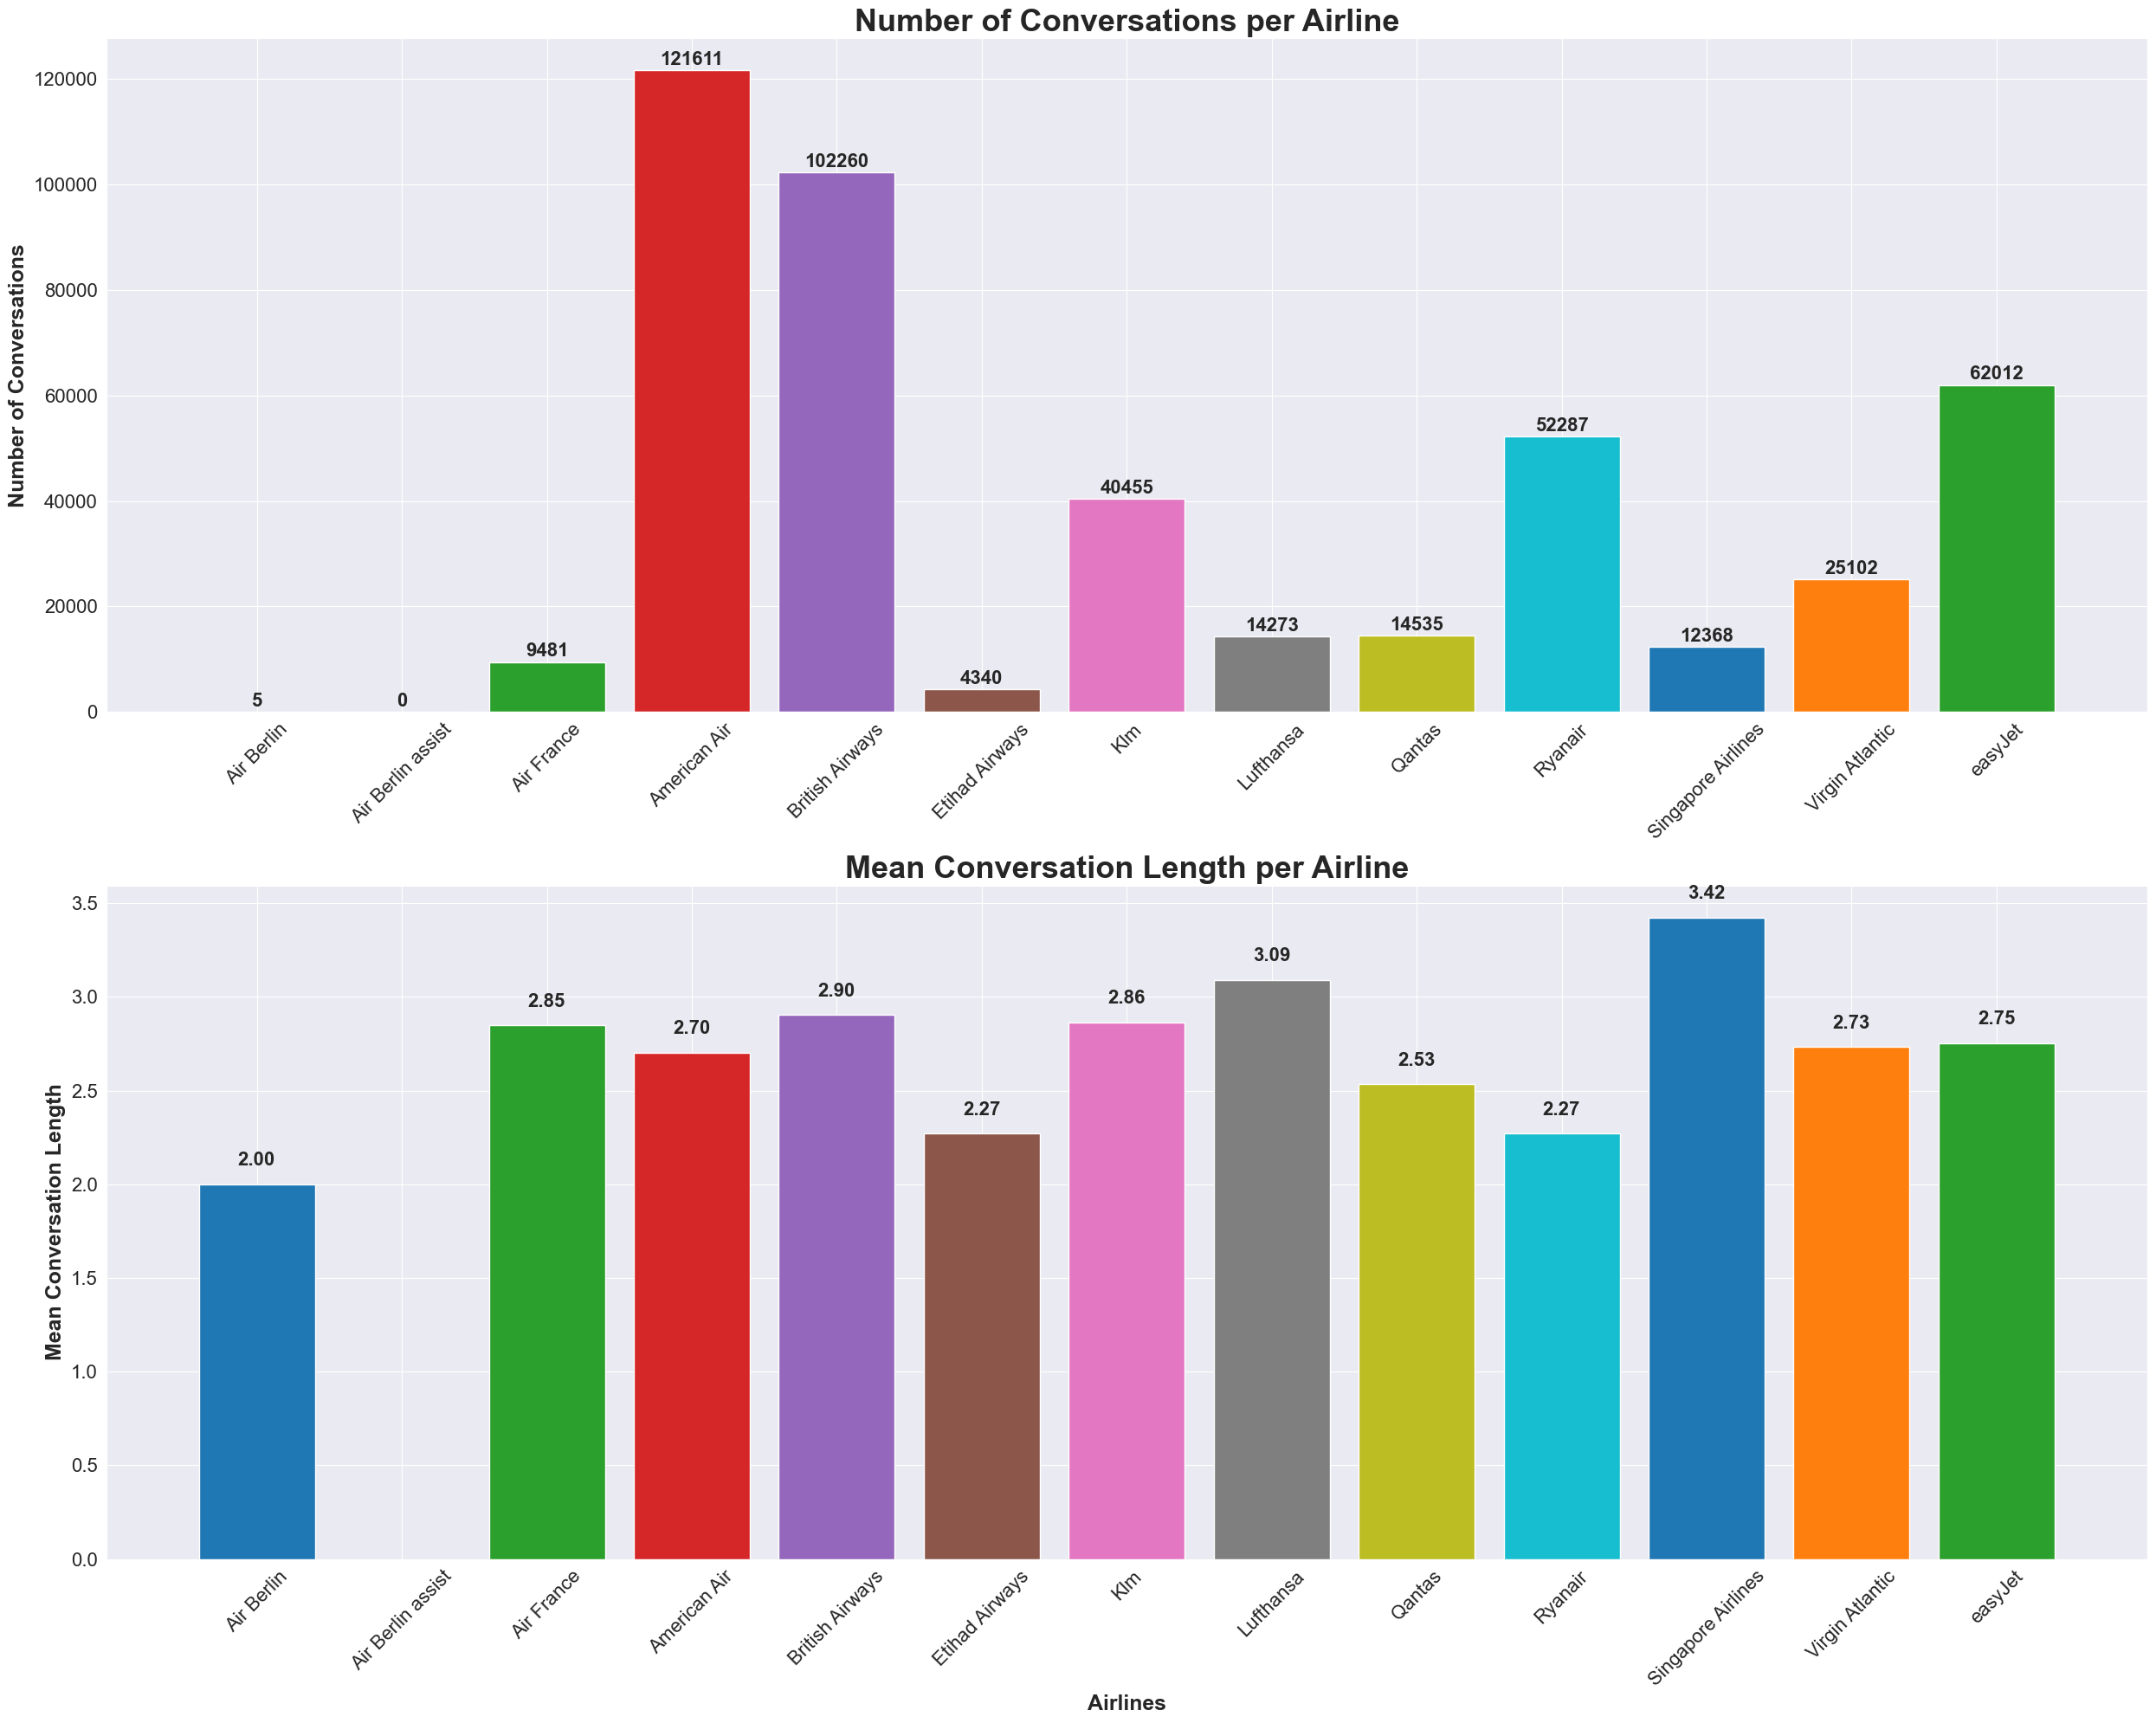

In [158]:
# Calculate the number of conversations per user and create a mapping to user names
user_conversations_count = {
    COMPANY_ID_TO_NAME[user_id]: df_reset[df_reset['user_id'] == user_id]['conversation_id'].nunique()
    for user_id in COMPANY_ID_LIST
}

# Use a predefined color scheme
colors = list(mcolors.TABLEAU_COLORS.values())

# Sort the dictionary by airline names alphabetically
sorted_user_conversations_count = dict(sorted(user_conversations_count.items()))

# Calculate the mean conversation length per airline
conversation_lengths = df_reset.groupby('conversation_id').size().reset_index(name='conversation_length')
df_airline_count = df_reset.dropna(subset=['airline']).groupby('conversation_id')['airline'].first().reset_index()
mean_conversation_length = pd.merge(df_airline_count, conversation_lengths, on='conversation_id').groupby('airline').mean()['conversation_length']
sorted_mean_conversation_length = mean_conversation_length.reindex(sorted_user_conversations_count.keys())

# Plot the number of conversations per airline
plt.figure(figsize=(25, 20))
plt.subplot(2, 1, 1)
bars1 = plt.bar(sorted_user_conversations_count.keys(), sorted_user_conversations_count.values(), color=colors[:len(sorted_user_conversations_count)])
plt.ylabel('Number of Conversations', fontsize=18, fontweight='bold')
plt.title('Number of Conversations per Airline', fontsize=26, fontweight='bold')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Add data labels on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', fontsize=16, fontweight='bold')

# Plot the mean conversation length per airline
plt.subplot(2, 1, 2)
bars2 = plt.bar(sorted_mean_conversation_length.index, sorted_mean_conversation_length.values, color=colors[:len(sorted_mean_conversation_length)])
plt.xlabel('Airlines', fontsize=18, fontweight='bold')
plt.ylabel('Mean Conversation Length', fontsize=18, fontweight='bold')
plt.title('Mean Conversation Length per Airline', fontsize=26, fontweight='bold')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Add data labels on top of each bar
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, f'{yval:.2f}', ha='center', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

## Distribution of Conversation Length

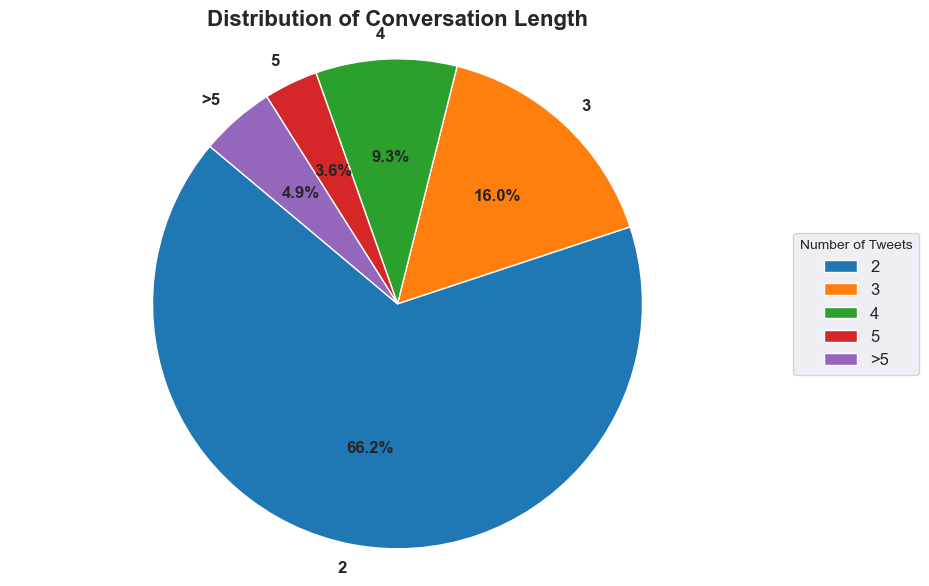

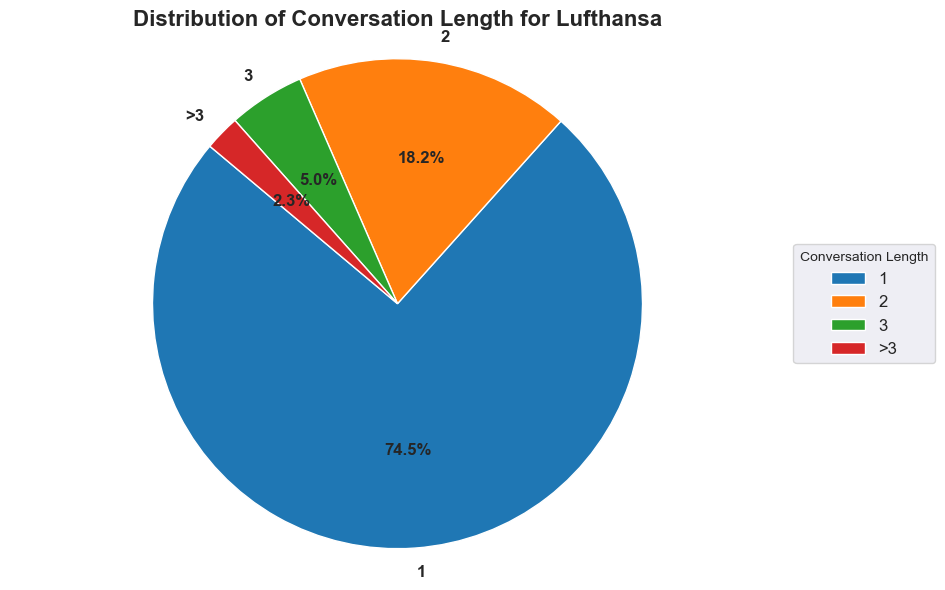

In [159]:
# Define a function to process the data
def process_conversation_data(df, user_id=None, bins=None, labels=None):
    if user_id:
        df = df[df['user_id'] == user_id]
    
    conversation_lengths = df.groupby('conversation_id').size().reset_index(name='conversation_length')

    if bins and labels:
        conversation_lengths['length_bin'] = pd.cut(conversation_lengths['conversation_length'], bins=bins, labels=labels, right=False)
        length_distribution = conversation_lengths['length_bin'].value_counts().sort_index()
    else:
        conversation_lengths['conversation_length'] = conversation_lengths['conversation_length'].apply(lambda x: str(x) if x <= 5 else '>5')
        length_distribution = conversation_lengths['conversation_length'].value_counts().sort_index()
    
    return length_distribution

# Define a function to plot the data
def plot_pie_chart(distribution, title, legend_title):
    colors = list(mcolors.TABLEAU_COLORS.values())
    
    plt.figure(figsize=(10, 7))
    patches, texts, autotexts = plt.pie(distribution, labels=distribution.index, autopct='%1.1f%%', startangle=140, colors=colors[:len(distribution)])
    
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')

    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')
    
    plt.legend(patches, distribution.index, title=legend_title, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Process and plot the data for the general case
conversation_counts_dist = process_conversation_data(df_reset)
plot_pie_chart(conversation_counts_dist, 'Distribution of Conversation Length', 'Number of Tweets')

# Process and plot the data for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
bins = [1, 2, 3, 4, float('inf')]
labels = ['1', '2', '3', '>3']
lufthansa_conversation_lengths_dist = process_conversation_data(df_reset, user_id=lufthansa_user_id, bins=bins, labels=labels)
plot_pie_chart(lufthansa_conversation_lengths_dist, 'Distribution of Conversation Length for Lufthansa', 'Conversation Length')

## Time patterns
### Number of conversations per month

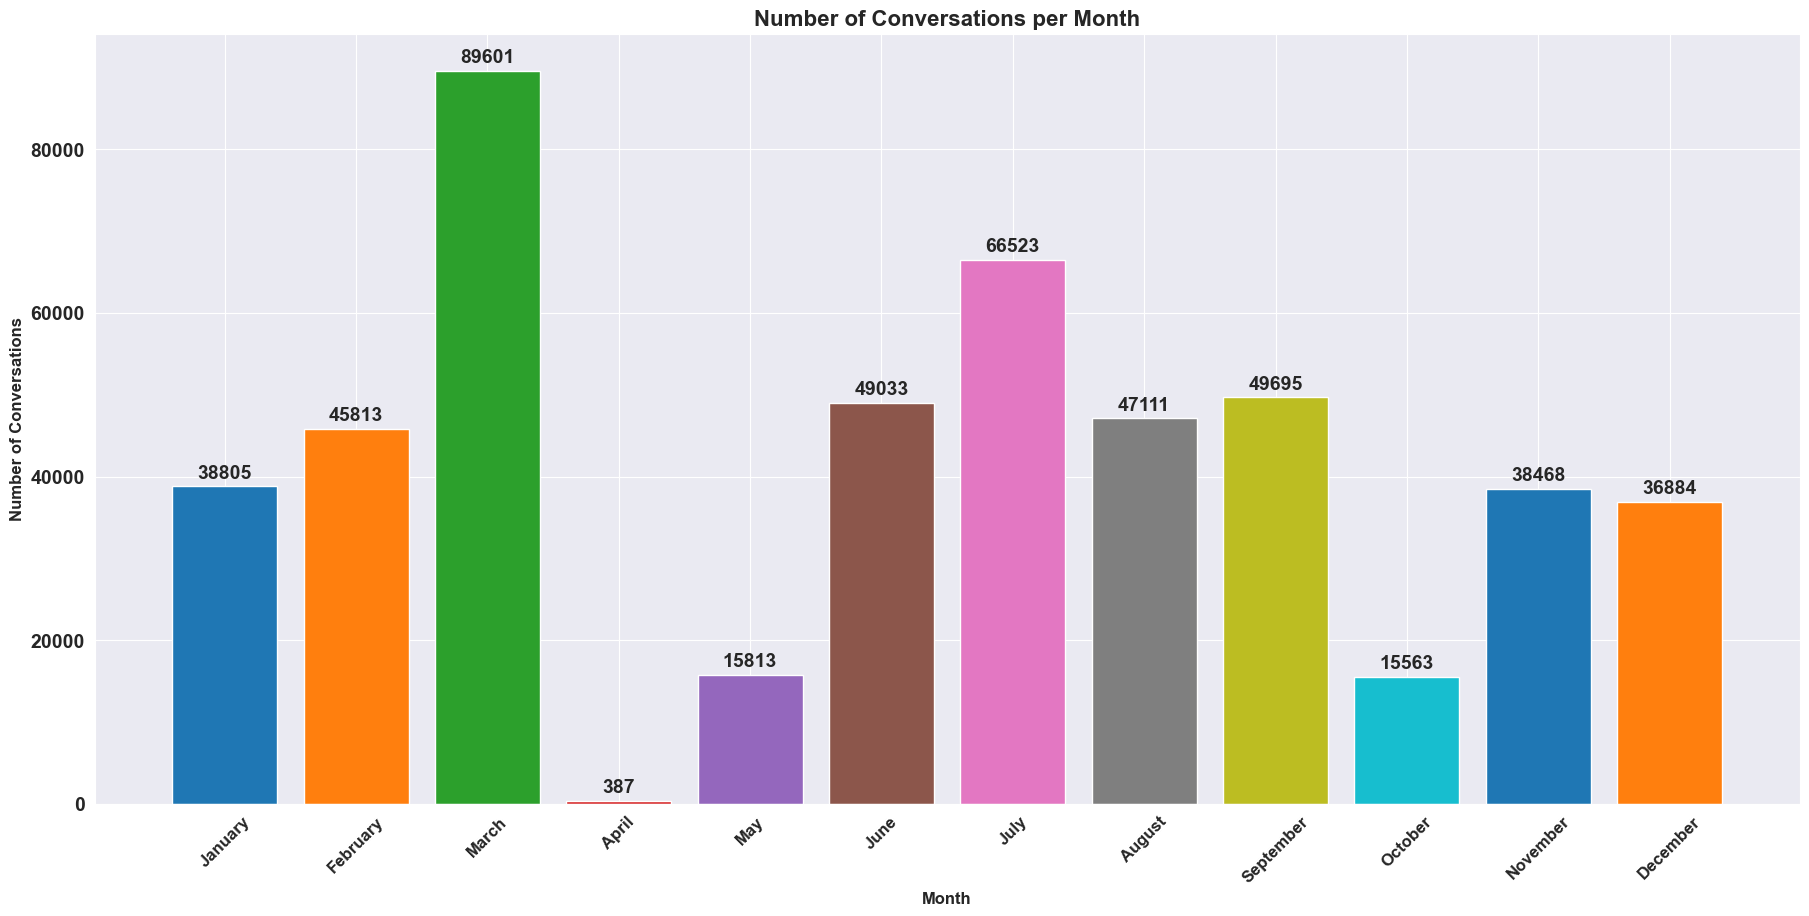

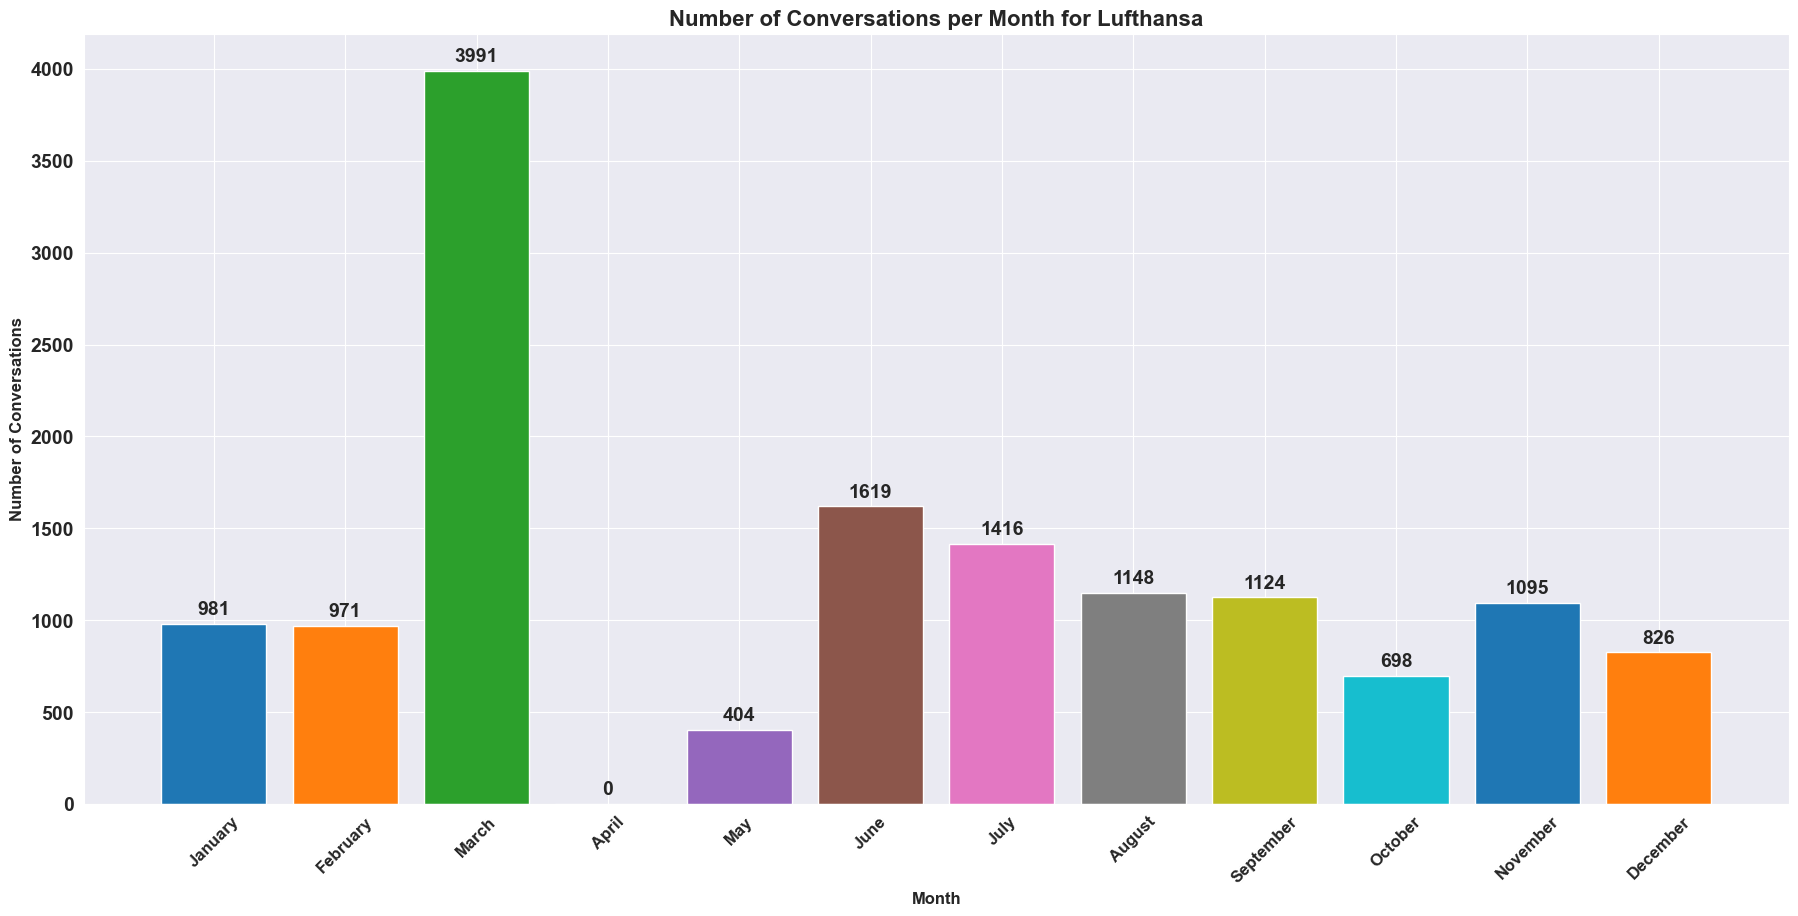

In [160]:
# Define a function to process the data
def process_conversations_per_month(df, user_id=None):
    if user_id:
        df = df[df['user_id'] == user_id].copy()

    df['tweet_creation_time'] = pd.to_datetime(df['tweet_creation_time'])
    
    # Extract the first tweet's creation time for each conversation
    first_tweet_times = df.groupby('conversation_id')['tweet_creation_time'].min()
    
    # Extract the month name from the tweet creation time
    first_tweet_times_month = first_tweet_times.dt.month_name()
    
    # Group by month name and count the number of conversations
    conversations_per_month = first_tweet_times_month.value_counts().reindex([
        'January', 'February', 'March', 'April', 'May', 'June', 
        'July', 'August', 'September', 'October', 'November', 'December'
    ], fill_value=0)
    
    return conversations_per_month

# Define a function to plot the bar chart
def plot_bar_chart(conversations_per_month, title, xlabel, ylabel, bar_label_offset=1000):
    colors = list(mcolors.TABLEAU_COLORS.values())
    
    plt.figure(figsize=(22, 10))
    bars = plt.bar(conversations_per_month.index, conversations_per_month.values, color=colors[:len(conversations_per_month)])
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')

    # Add data labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + bar_label_offset, int(yval), ha='center', fontsize=14, fontweight='bold')

    plt.show()

# Process and plot the data for the general case
conversations_per_month = process_conversations_per_month(df_reset)
plot_bar_chart(conversations_per_month, 'Number of Conversations per Month', 'Month', 'Number of Conversations')

# Process and plot the data for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
conversations_per_month_lufthansa = process_conversations_per_month(df_reset, user_id=lufthansa_user_id)
plot_bar_chart(conversations_per_month_lufthansa, "Number of Conversations per Month for Lufthansa", 'Month', 'Number of Conversations', bar_label_offset=50)

### Number of conversations per day of the week

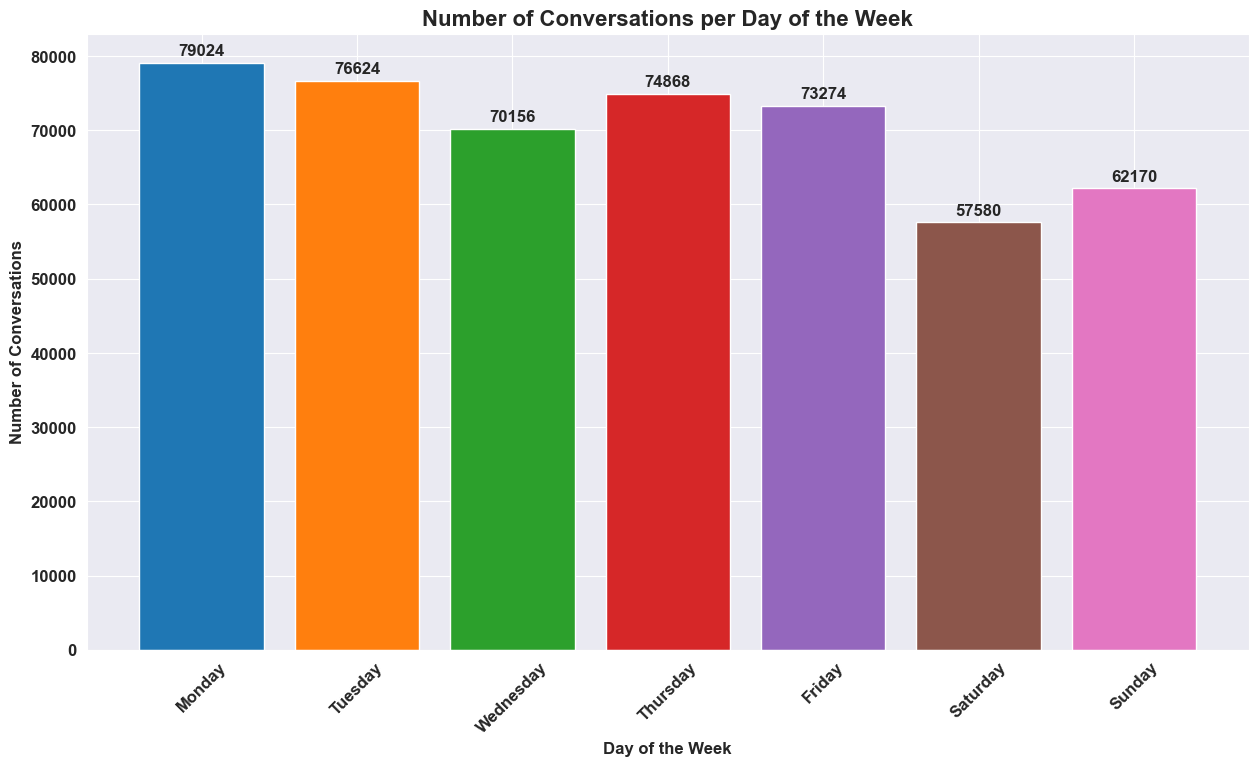

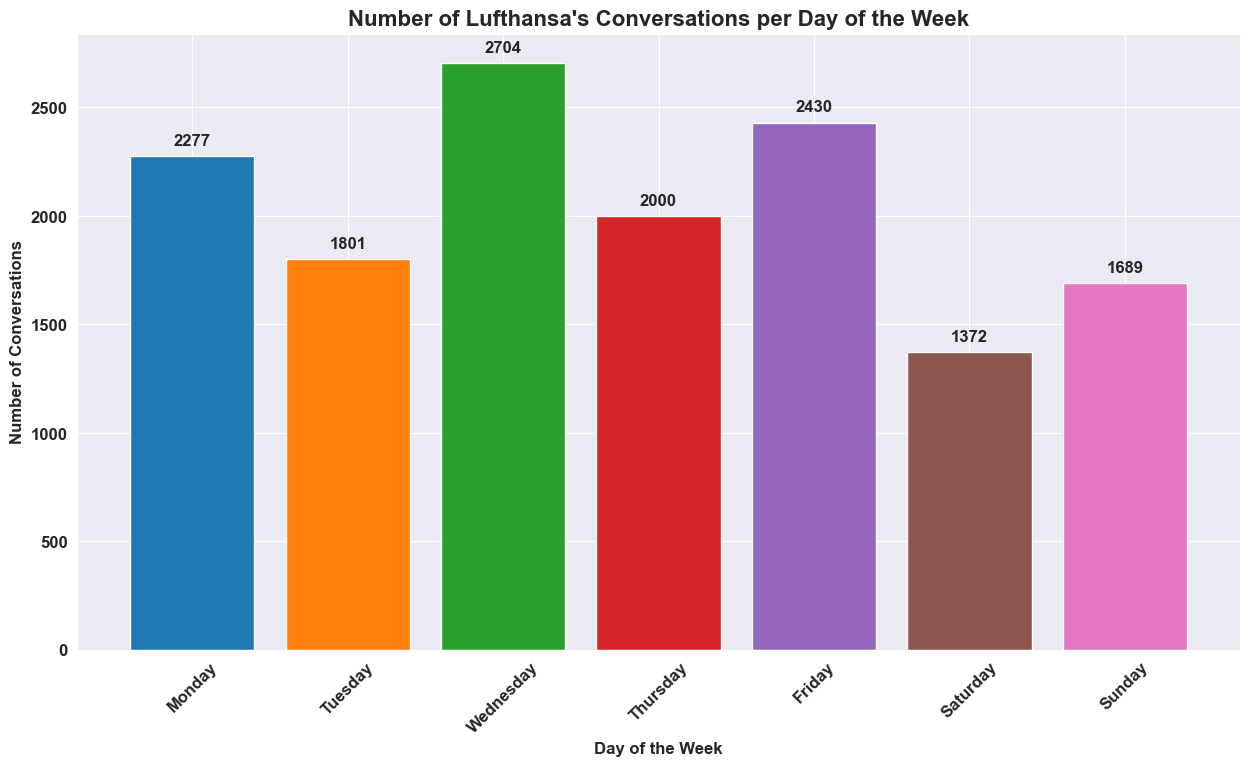

In [161]:
# Define a function to process the data
def process_conversations_per_day(df, user_id=None):
    if user_id:
        df = df[df['user_id'] == user_id].copy()

    df['tweet_creation_time'] = pd.to_datetime(df['tweet_creation_time'])
    
    # Extract the first tweet's creation time for each conversation
    first_tweet_times = df.groupby('conversation_id')['tweet_creation_time'].min()
    
    # Extract the day name from the tweet creation time
    first_tweet_times_day = first_tweet_times.dt.day_name()
    
    # Group by day name and count the number of conversations
    conversations_per_day = first_tweet_times_day.value_counts().reindex([
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
    ], fill_value=0)
    
    return conversations_per_day

# Define a function to plot the bar chart
def plot_bar_chart(conversations_per_day, title, xlabel, ylabel, bar_label_offset=1000):
    colors = list(mcolors.TABLEAU_COLORS.values())
    
    plt.figure(figsize=(15, 8))
    bars = plt.bar(conversations_per_day.index, conversations_per_day.values, color=colors[:len(conversations_per_day)])
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    # Add data labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + bar_label_offset, int(yval), ha='center', fontsize=12, fontweight='bold')

    plt.show()

# Process and plot the data for the general case
conversations_per_day = process_conversations_per_day(df_reset)
plot_bar_chart(conversations_per_day, 'Number of Conversations per Day of the Week', 'Day of the Week', 'Number of Conversations')

# Process and plot the data for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
conversations_per_day_lufthansa = process_conversations_per_day(df_reset, user_id=lufthansa_user_id)
plot_bar_chart(conversations_per_day_lufthansa, "Number of Lufthansa's Conversations per Day of the Week", 'Day of the Week', 'Number of Conversations', bar_label_offset=50)

## Airline response time

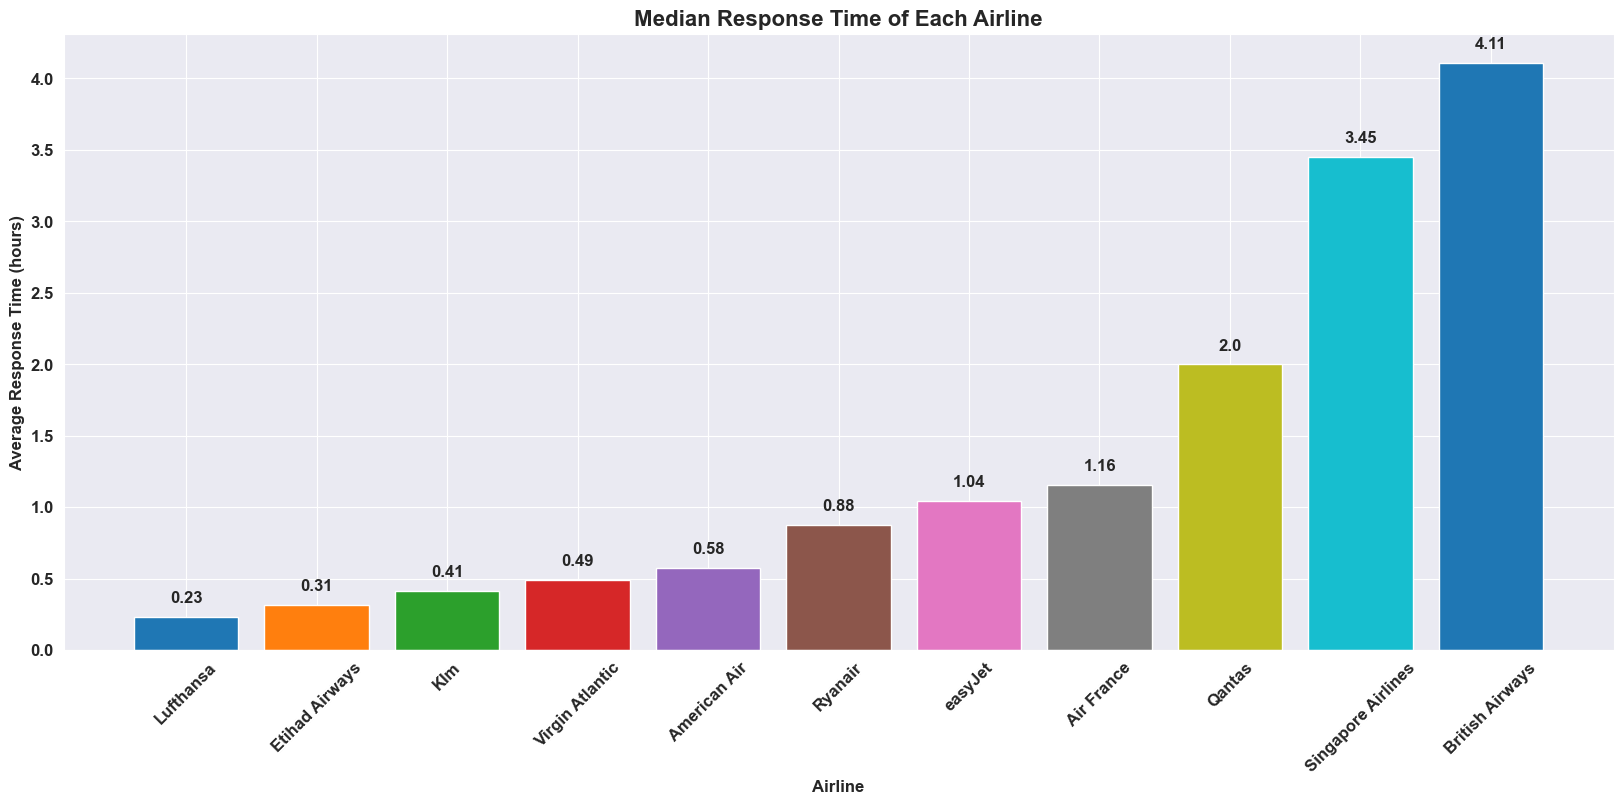

posx and posy should be finite values
posx and posy should be finite values


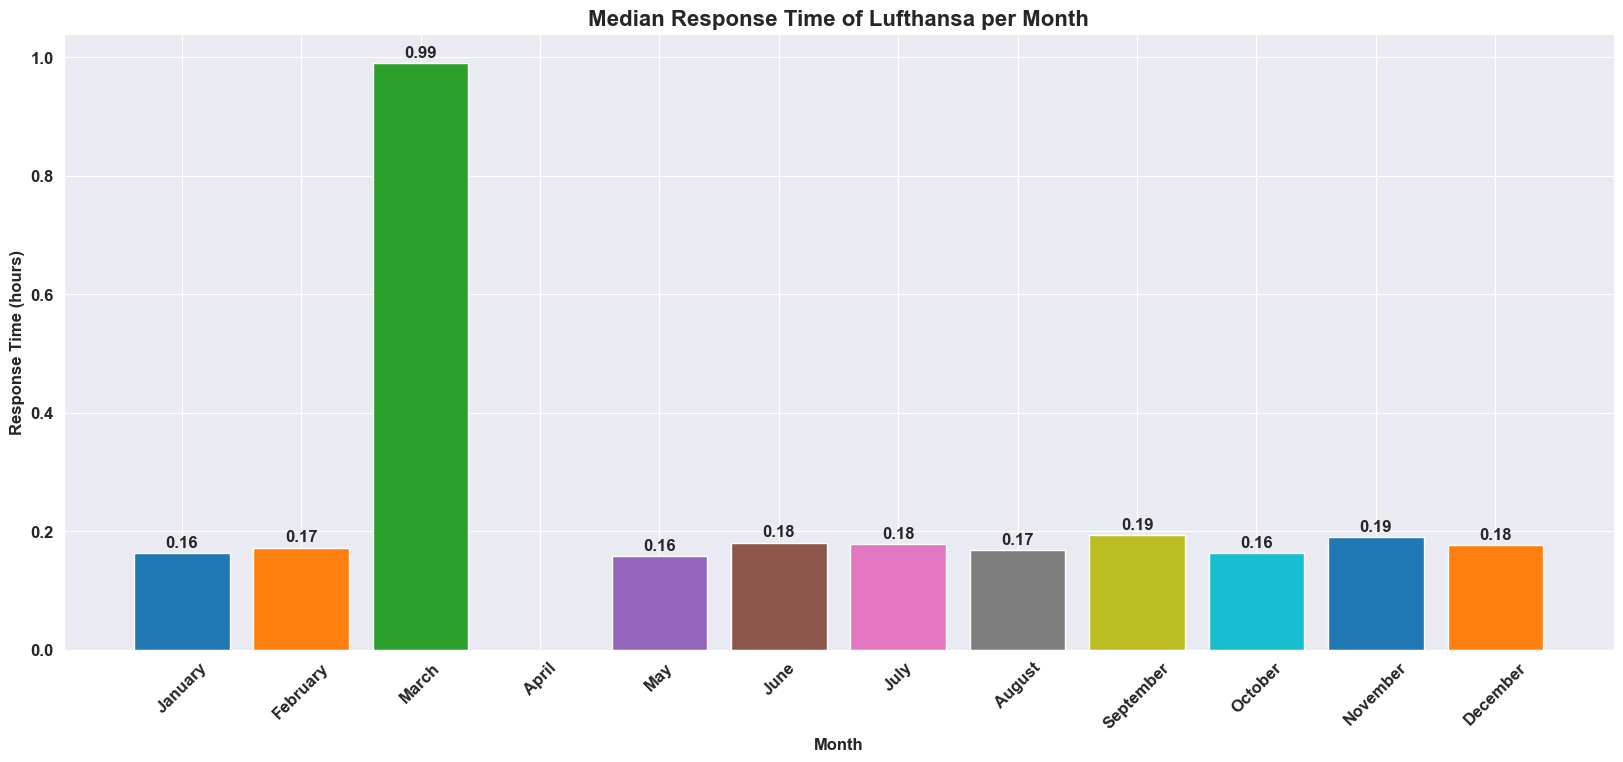

In [162]:
# Define a function to process the data for average response times
def process_average_response_times(df, user_id=None, group_by='airline'):
    df['tweet_creation_time'] = pd.to_datetime(df['tweet_creation_time'])

    # Precompute the first tweet time for each conversation
    first_tweet_times = df.groupby('conversation_id')['tweet_creation_time'].transform('min')

    # Compute the response times for all tweets
    df['response_time'] = (df['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours

    if user_id:
        df_filtered = df[(df['user_id'] == user_id) & (df['response_time'] > 0)].copy()
        df_filtered['month'] = df_filtered['tweet_creation_time'].dt.month_name()
        average_response_times = df_filtered.groupby('month')['response_time'].median().reindex([
            'January', 'February', 'March', 'April', 'May', 'June', 
            'July', 'August', 'September', 'October', 'November', 'December'
        ])
    else:
        df_filtered = df[df['user_id'].isin(COMPANY_NAME_TO_ID.values()) & (df['response_time'] > 0)].copy()
        df_filtered['airline'] = df_filtered['user_id'].map(COMPANY_ID_TO_NAME)
        average_response_times = df_filtered.groupby('airline')['response_time'].median().sort_values()
    
    return average_response_times

# Define a function to plot the bar chart
def plot_bar_chart(data, title, xlabel, ylabel, bar_label_offset=0.1):
    colors = list(mcolors.TABLEAU_COLORS.values())
    
    plt.figure(figsize=(20, 8))
    bars = plt.bar(data.index, data.values, color=colors[:len(data)])
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    # Add data labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + bar_label_offset, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

    plt.show()

# Process and plot the data for the general case
average_response_times = process_average_response_times(df_reset)
plot_bar_chart(average_response_times, 'Median Response Time of Each Airline', 'Airline', 'Average Response Time (hours)')

# Process and plot the data for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
average_response_times_lufthansa = process_average_response_times(df_reset, user_id=lufthansa_user_id)
plot_bar_chart(average_response_times_lufthansa, 'Median Response Time of Lufthansa per Month', 'Month', 'Response Time (hours)', bar_label_offset=0.01)

## Sentiment
### Distribution of sentiment scores
#### Histograms

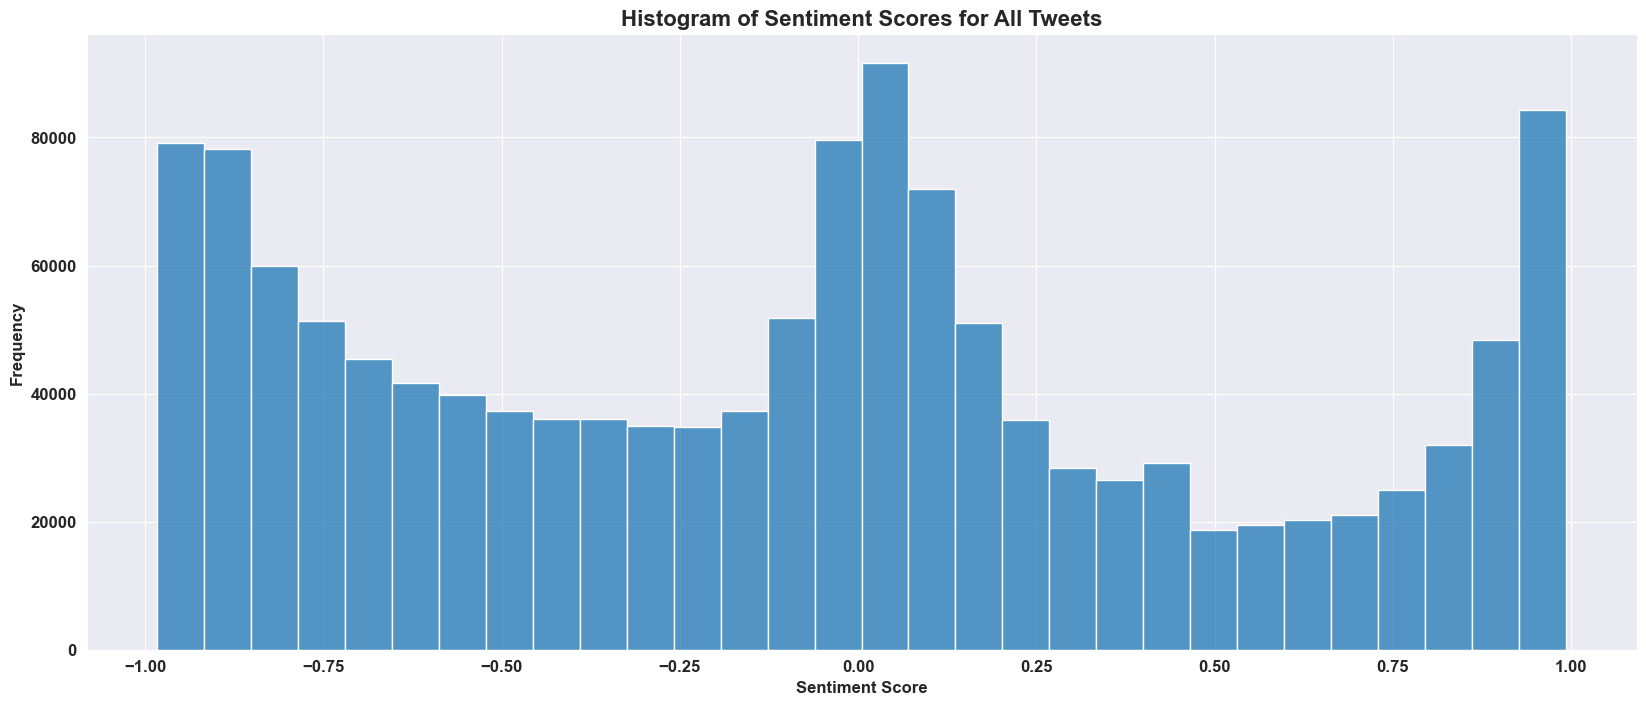

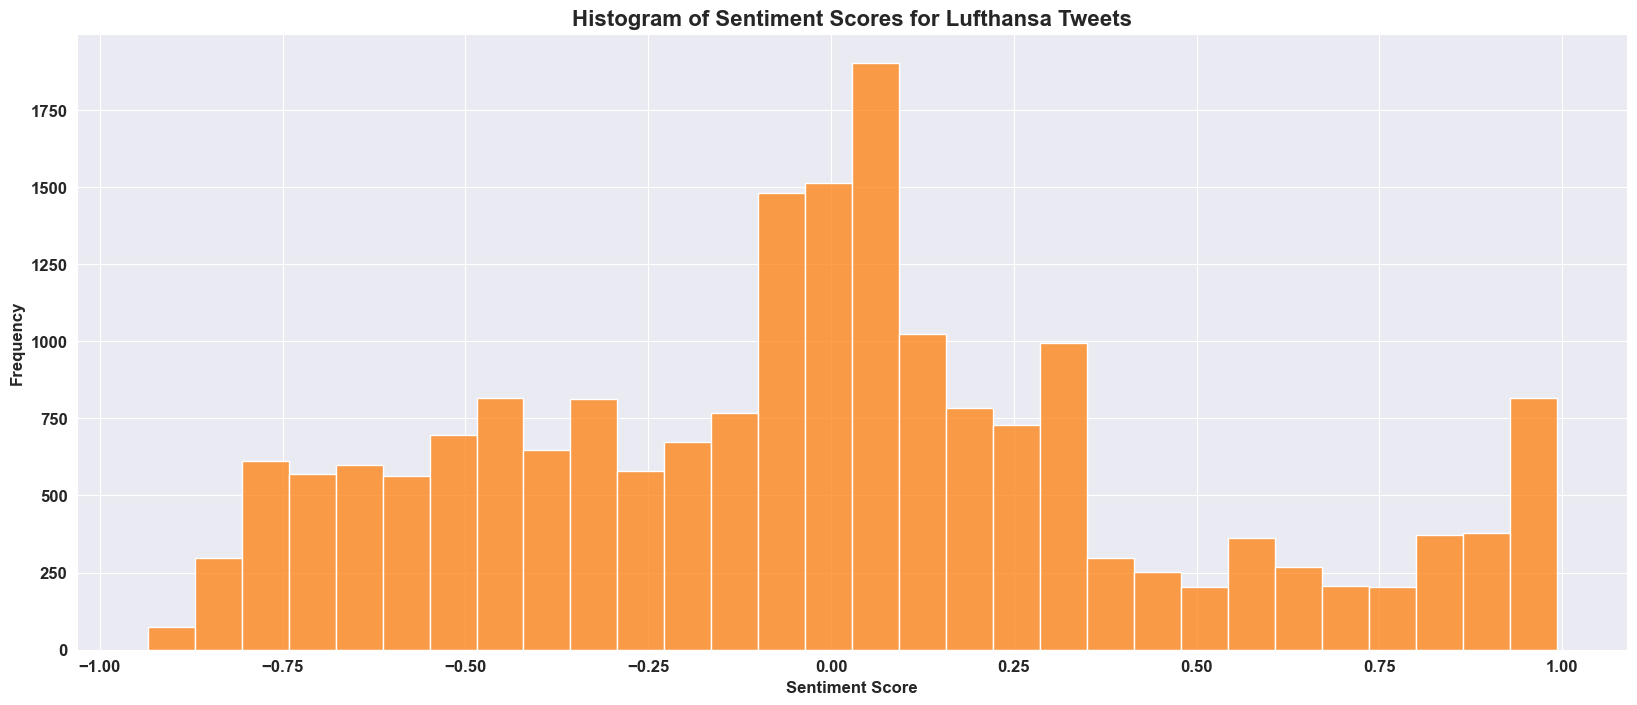

In [163]:
def process_sentiment_scores(df, user_id=None):
    df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')
    
    if user_id:
        df = df[df['user_id'] == user_id].copy()
    
    sentiment_scores = df['sentiment_score'].dropna()
    
    return sentiment_scores

# Define a function to plot the histogram
def plot_histogram(data, title, xlabel, ylabel, color):
    plt.figure(figsize=(20, 8))
    sns.histplot(data, bins=30, color=color, kde=False)
    
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.show()

# Define colormap
cmap = mcolors.TABLEAU_COLORS

# Process and plot the data for all tweets
all_sentiment_scores = process_sentiment_scores(df_reset)
plot_histogram(all_sentiment_scores, 'Histogram of Sentiment Scores for All Tweets', 'Sentiment Score', 'Frequency', list(cmap.values())[0])

# Process and plot the data for Lufthansa tweets
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_sentiment_scores = process_sentiment_scores(df_reset, user_id=lufthansa_user_id)
plot_histogram(lufthansa_sentiment_scores, 'Histogram of Sentiment Scores for Lufthansa Tweets', 'Sentiment Score', 'Frequency', list(cmap.values())[1])

#### Whisker plots

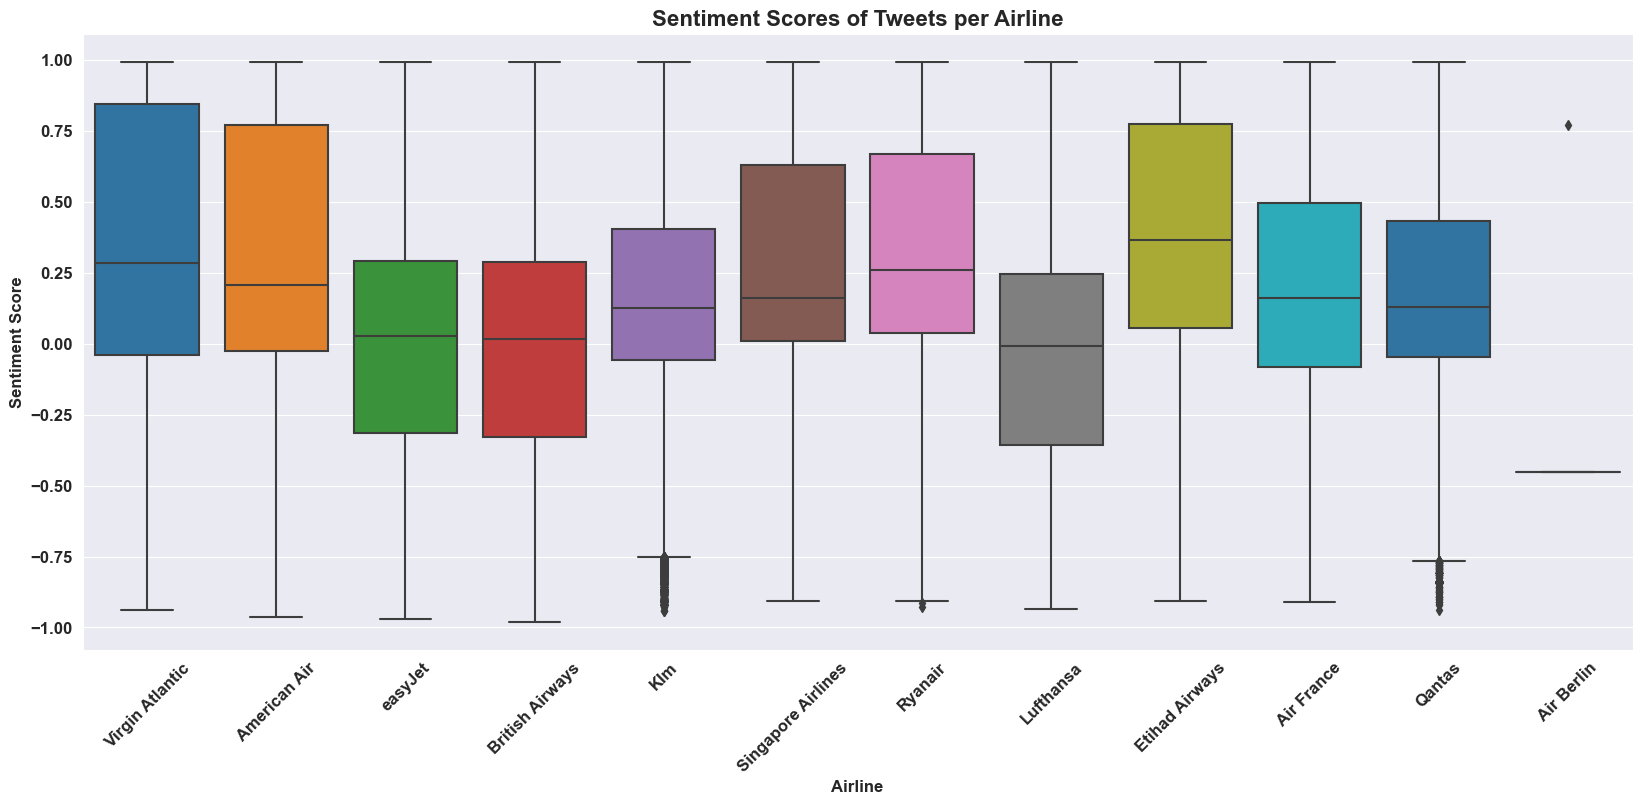

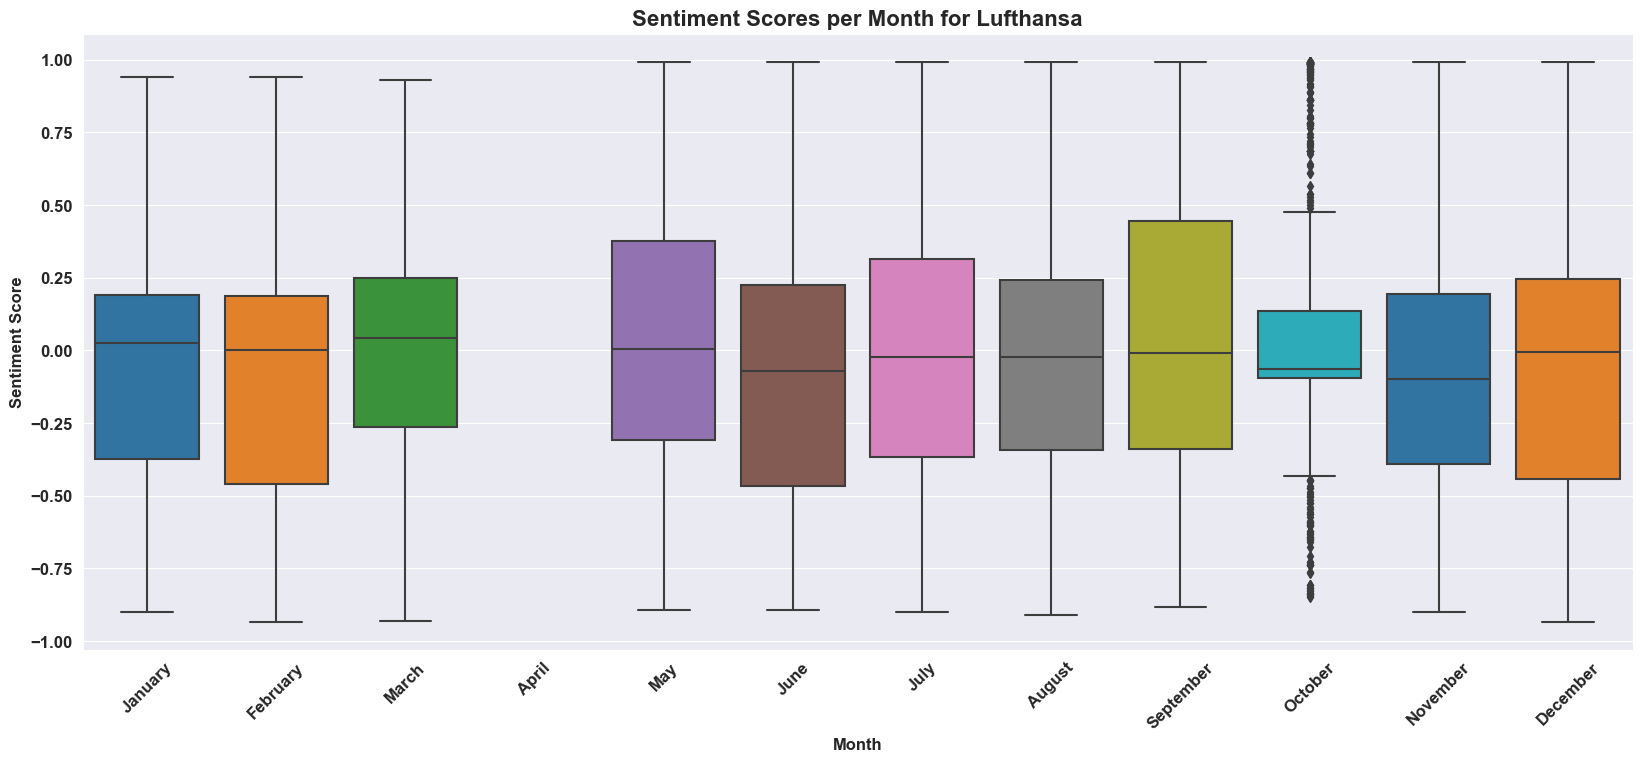

In [164]:
# Define a function to process sentiment scores and map user IDs to airline names
def process_airline_sentiment_scores(df, user_id=None, group_by='airline'):
    df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')
    
    if group_by == 'airline':
        df['airline'] = df['user_id'].map(COMPANY_ID_TO_NAME)
        if user_id:
            df = df[df['user_id'] == user_id].copy()
        df = df[df['airline'].notnull()]
    elif group_by == 'month':
        if user_id:
            df = df[df['user_id'] == user_id].copy()
        df['month'] = df['tweet_creation_time'].dt.strftime('%B')
    
    return df

# Define a function to plot the box plot
def plot_box_plot(data, x, y, title, xlabel, ylabel, order=None, palette=None):
    plt.figure(figsize=(20, 8))
    sns.boxplot(x=x, y=y, data=data, order=order, palette=palette)
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.show()

# Define colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Process and plot the data for sentiment scores per airline
airline_tweets = process_airline_sentiment_scores(df_reset)
palette = {airline: colors[i % len(colors)] for i, airline in enumerate(airline_tweets['airline'].unique())}
plot_box_plot(airline_tweets, 'airline', 'sentiment_score', 'Sentiment Scores of Tweets per Airline', 'Airline', 'Sentiment Score', palette=palette)

# Process and plot the data for sentiment scores per month for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_tweets = process_airline_sentiment_scores(df_reset, user_id=lufthansa_user_id, group_by='month')
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
plot_box_plot(lufthansa_tweets, 'month', 'sentiment_score', 'Sentiment Scores per Month for Lufthansa', 'Month', 'Sentiment Score', order=month_order, palette=colors[:12])

### Sentiment scores per day of the week

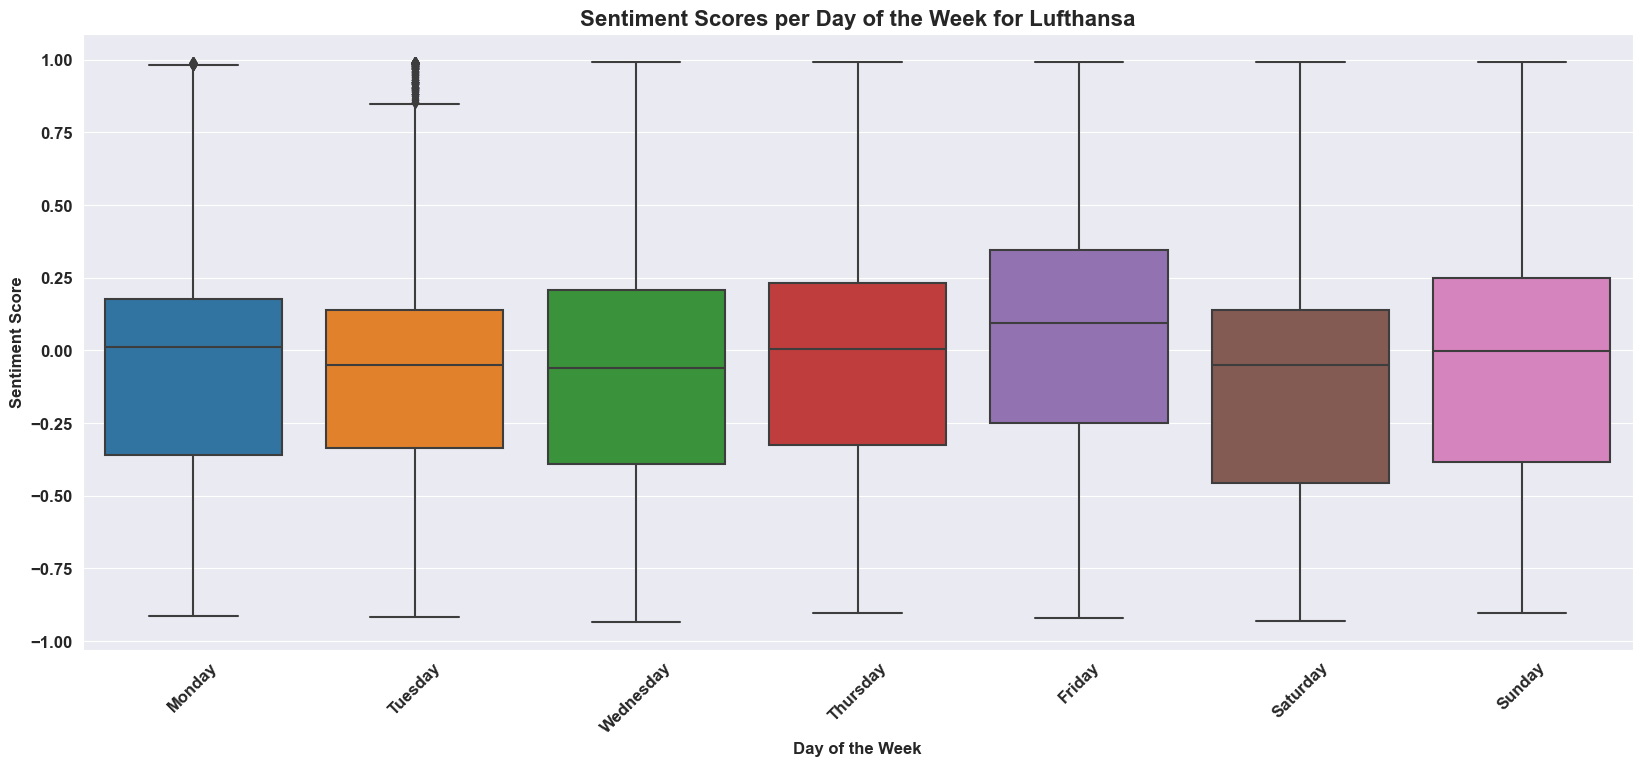

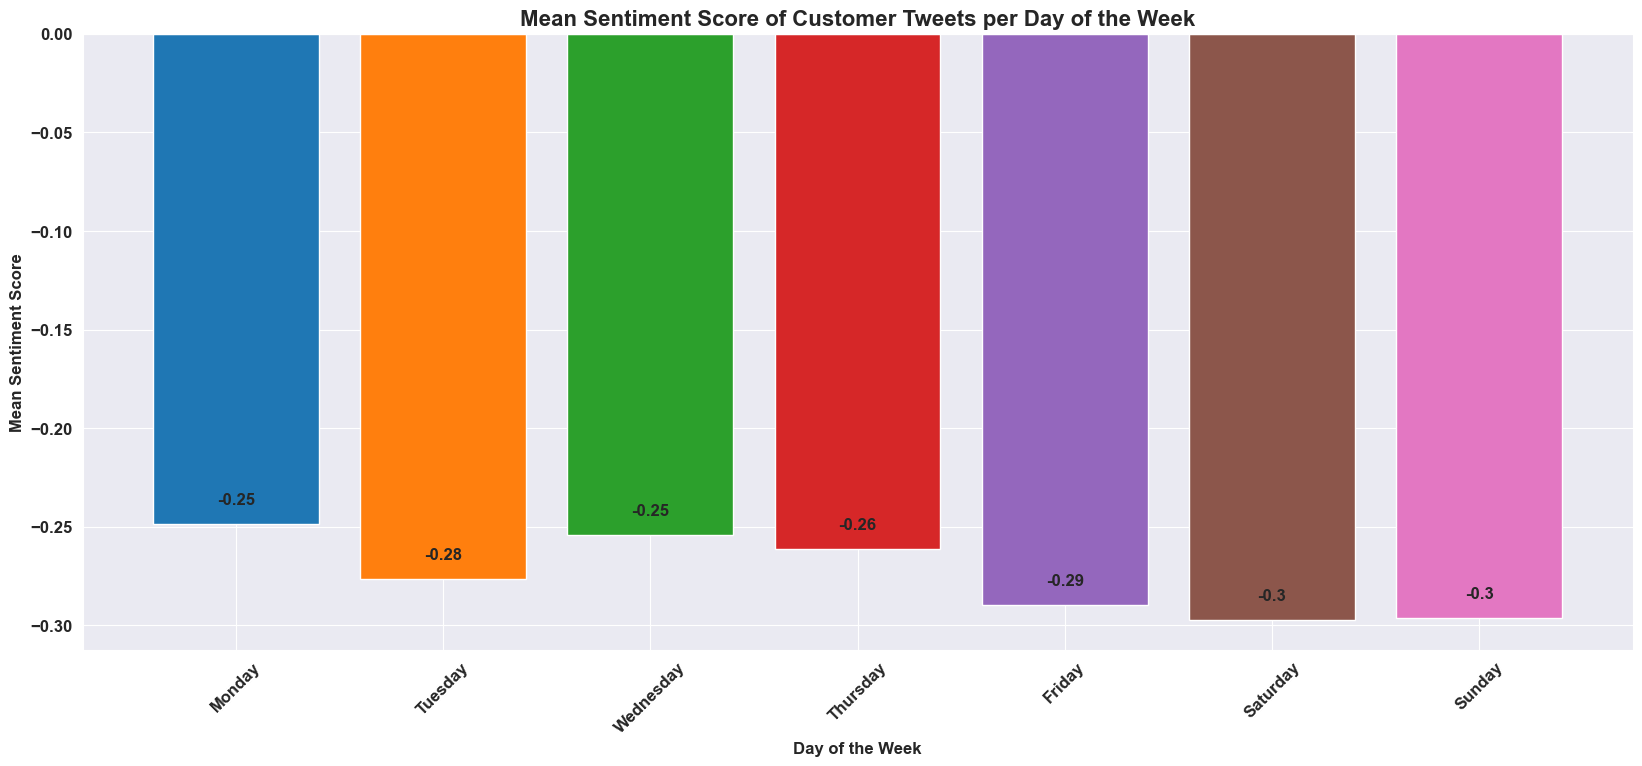

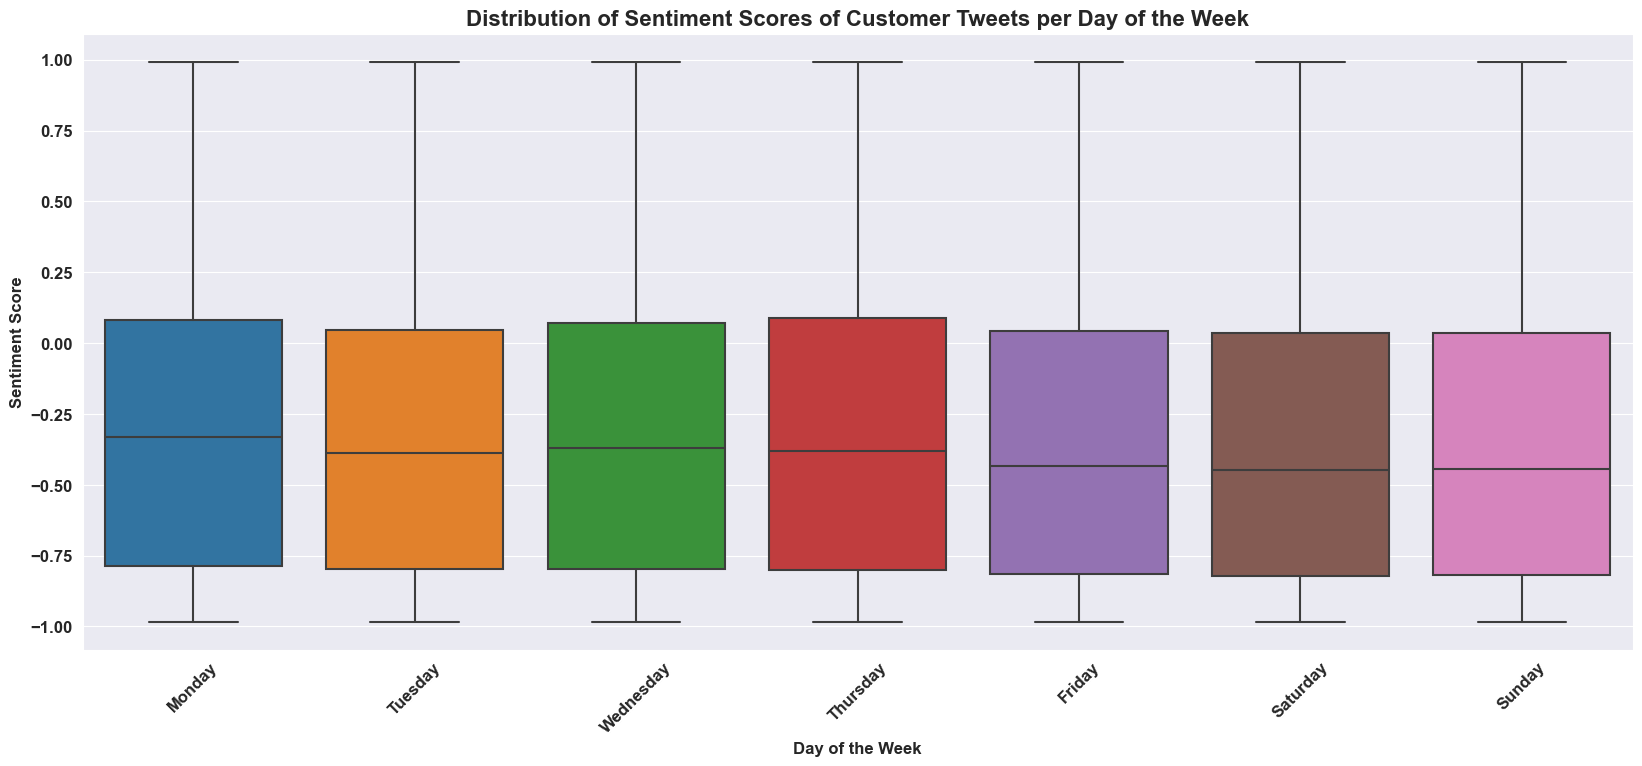

In [165]:
# Define a function to process sentiment scores and add day of the week
def process_day_of_week_sentiment(df, user_id=None, exclude_airlines=False):
    df['tweet_creation_time'] = pd.to_datetime(df['tweet_creation_time'])
    df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')
    
    if user_id:
        df = df[df['user_id'] == user_id].copy()
    if exclude_airlines:
        df = df[~df['user_id'].isin(COMPANY_NAME_TO_ID.values())].copy()
    
    df['day_of_week'] = df['tweet_creation_time'].dt.day_name()
    
    return df

# Define a function to plot the box plot
def plot_box_plot(data, x, y, title, xlabel, ylabel, order=None, palette=None):
    plt.figure(figsize=(20, 8))
    sns.boxplot(x=x, y=y, data=data, order=order, palette=palette)
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.show()

# Define a function to plot the bar chart
def plot_bar_chart(data, title, xlabel, ylabel, colors):
    plt.figure(figsize=(20, 8))
    bars = plt.bar(data.index, data.values, color=colors[:len(data)])
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    # Add data labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')
    
    plt.show()

# Define colormap
colors = list(mcolors.TABLEAU_COLORS.values())
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Process and plot the data for sentiment scores per day of the week for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_tweets = process_day_of_week_sentiment(df_reset, user_id=lufthansa_user_id)
plot_box_plot(lufthansa_tweets, 'day_of_week', 'sentiment_score', 'Sentiment Scores per Day of the Week for Lufthansa', 'Day of the Week', 'Sentiment Score', order=day_order, palette=colors[:7])

# Process and plot the data for mean sentiment scores per day of the week for customer tweets
customer_tweets = process_day_of_week_sentiment(df_reset, exclude_airlines=True)
mean_sentiment_per_day = customer_tweets.groupby('day_of_week')['sentiment_score'].mean().reindex(day_order)
plot_bar_chart(mean_sentiment_per_day, 'Mean Sentiment Score of Customer Tweets per Day of the Week', 'Day of the Week', 'Mean Sentiment Score', colors)

# Process and plot the data for sentiment scores per day of the week for customer tweets
plot_box_plot(customer_tweets, 'day_of_week', 'sentiment_score', 'Distribution of Sentiment Scores of Customer Tweets per Day of the Week', 'Day of the Week', 'Sentiment Score', order=day_order, palette=colors[:7])

### Sentiment scores per month

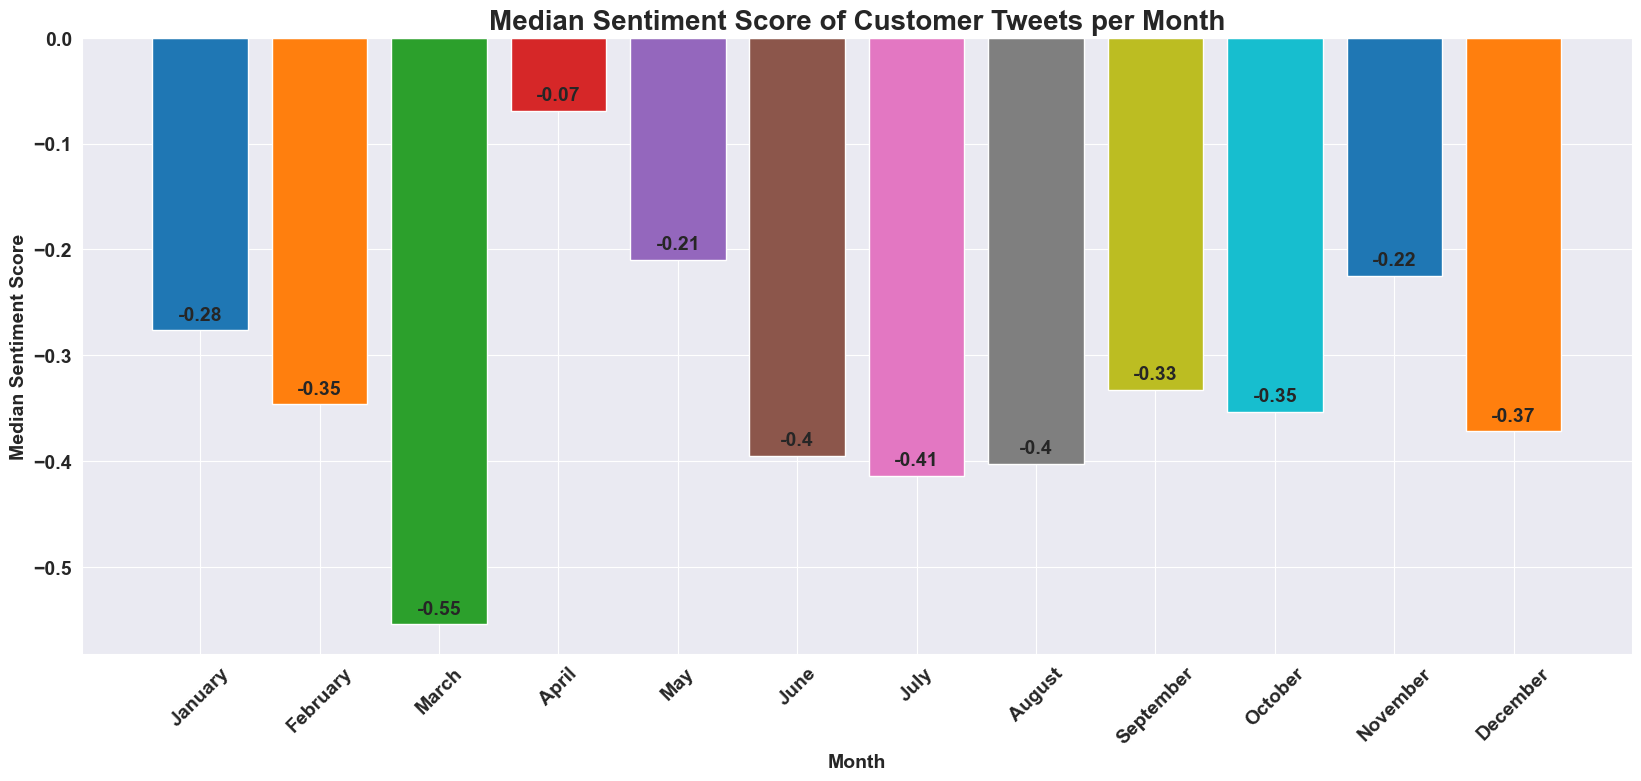

posx and posy should be finite values
posx and posy should be finite values


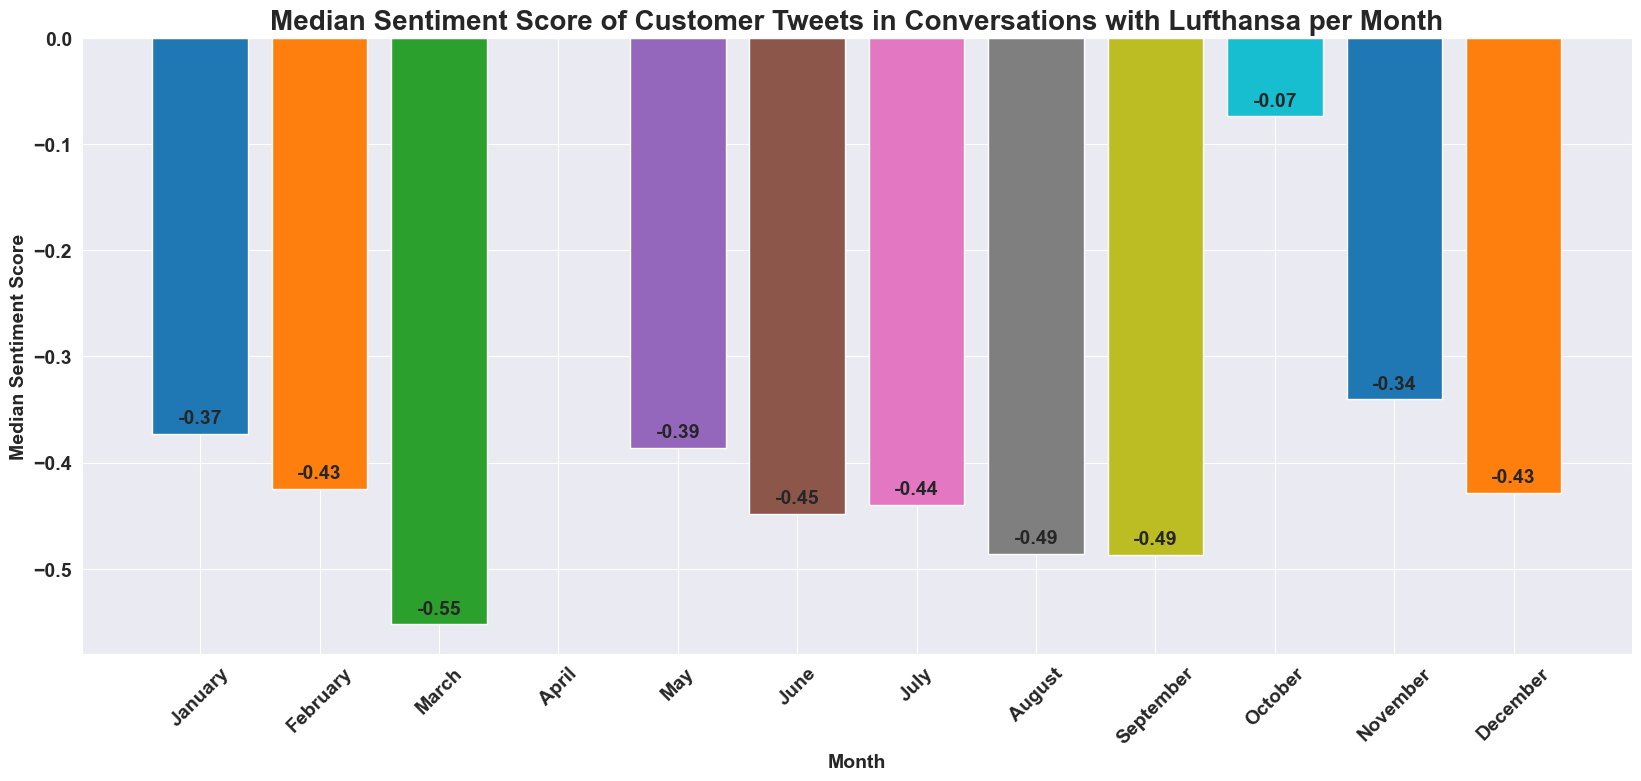

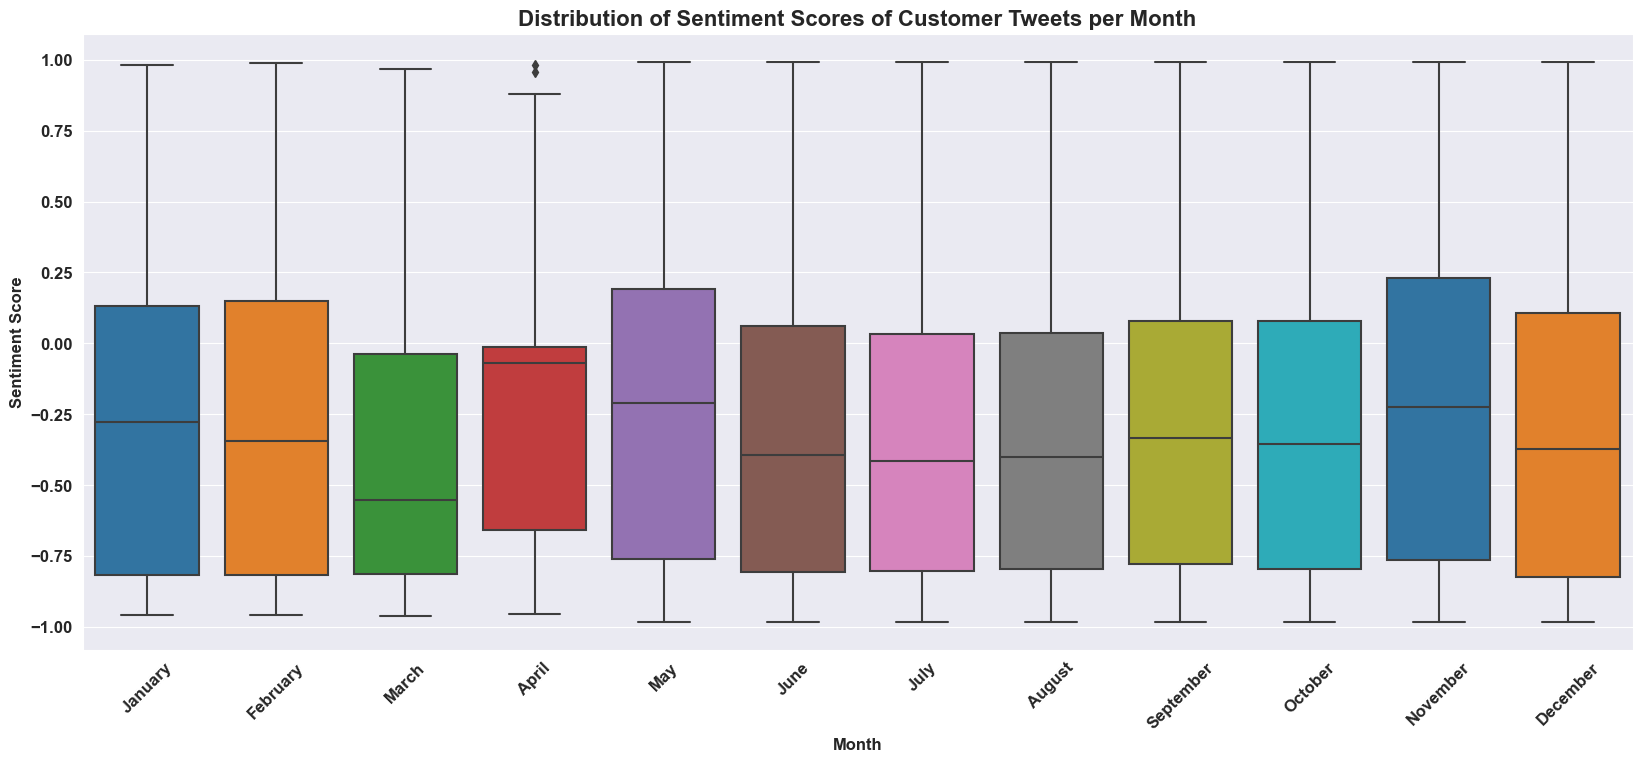

In [166]:
# Define a function to process sentiment scores and add month
def process_monthly_sentiment(df, user_id=None, exclude_airlines=False, lufthansa_conversations=False, compute_change=False):
    df['tweet_creation_time'] = pd.to_datetime(df['tweet_creation_time'])
    df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')
    
    if exclude_airlines:
        df = df[~df['user_id'].isin(COMPANY_NAME_TO_ID.values())].copy()
    if lufthansa_conversations:
        lufthansa_conversations = df[df['user_id'] == COMPANY_NAME_TO_ID['Lufthansa']]['conversation_id'].unique()
        df = df[df['conversation_id'].isin(lufthansa_conversations) & ~df['user_id'].isin(COMPANY_NAME_TO_ID.values())].copy()
    if compute_change:
        df['sentiment_change'] = df.groupby('conversation_id')['sentiment_score'].diff()
    
    df['month'] = df['tweet_creation_time'].dt.month_name()
    
    return df

# Define a function to plot the bar chart
def plot_bar_chart(data, title, xlabel, ylabel, colors, label_offset=0.01):
    plt.figure(figsize=(20, 8))
    bars = plt.bar(data.index, data.values, color=colors[:len(data)])
    plt.xlabel(xlabel, fontsize=14, fontweight='bold')
    plt.ylabel(ylabel, fontsize=14, fontweight='bold')
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xticks(rotation=45, fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')

    # Add data labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + label_offset, round(yval, 2), ha='center', fontsize=14, fontweight='bold')
    
    plt.show()

# Define a function to plot the box plot
def plot_box_plot(data, x, y, title, xlabel, ylabel, order, palette):
    plt.figure(figsize=(20, 8))
    sns.boxplot(x=x, y=y, data=data, order=order, palette=palette)
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.show()

# Define colormap and month order
colors = list(mcolors.TABLEAU_COLORS.values())
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# 1st Plot: Median Sentiment Score of Customer Tweets per Month
customer_tweets = process_monthly_sentiment(df_reset, exclude_airlines=True)
mean_sentiment_per_month = customer_tweets.groupby('month')['sentiment_score'].median().reindex(month_order)
plot_bar_chart(mean_sentiment_per_month, 'Median Sentiment Score of Customer Tweets per Month', 'Month', 'Median Sentiment Score', colors)

# 2nd Plot: Median Sentiment Score of Customer Tweets in Conversations with Lufthansa per Month
lufthansa_customer_tweets = process_monthly_sentiment(df_reset, lufthansa_conversations=True)
median_sentiment_per_month = lufthansa_customer_tweets.groupby('month')['sentiment_score'].median().reindex(month_order)
plot_bar_chart(median_sentiment_per_month, 'Median Sentiment Score of Customer Tweets in Conversations with Lufthansa per Month', 'Month', 'Median Sentiment Score', colors)

# 3rd Plot: Distribution of Sentiment Scores of Customer Tweets per Month
plot_box_plot(customer_tweets, 'month', 'sentiment_score', 'Distribution of Sentiment Scores of Customer Tweets per Month', 'Month', 'Sentiment Score', month_order, colors[:12])

### Sentiment scores change for a chose conversation

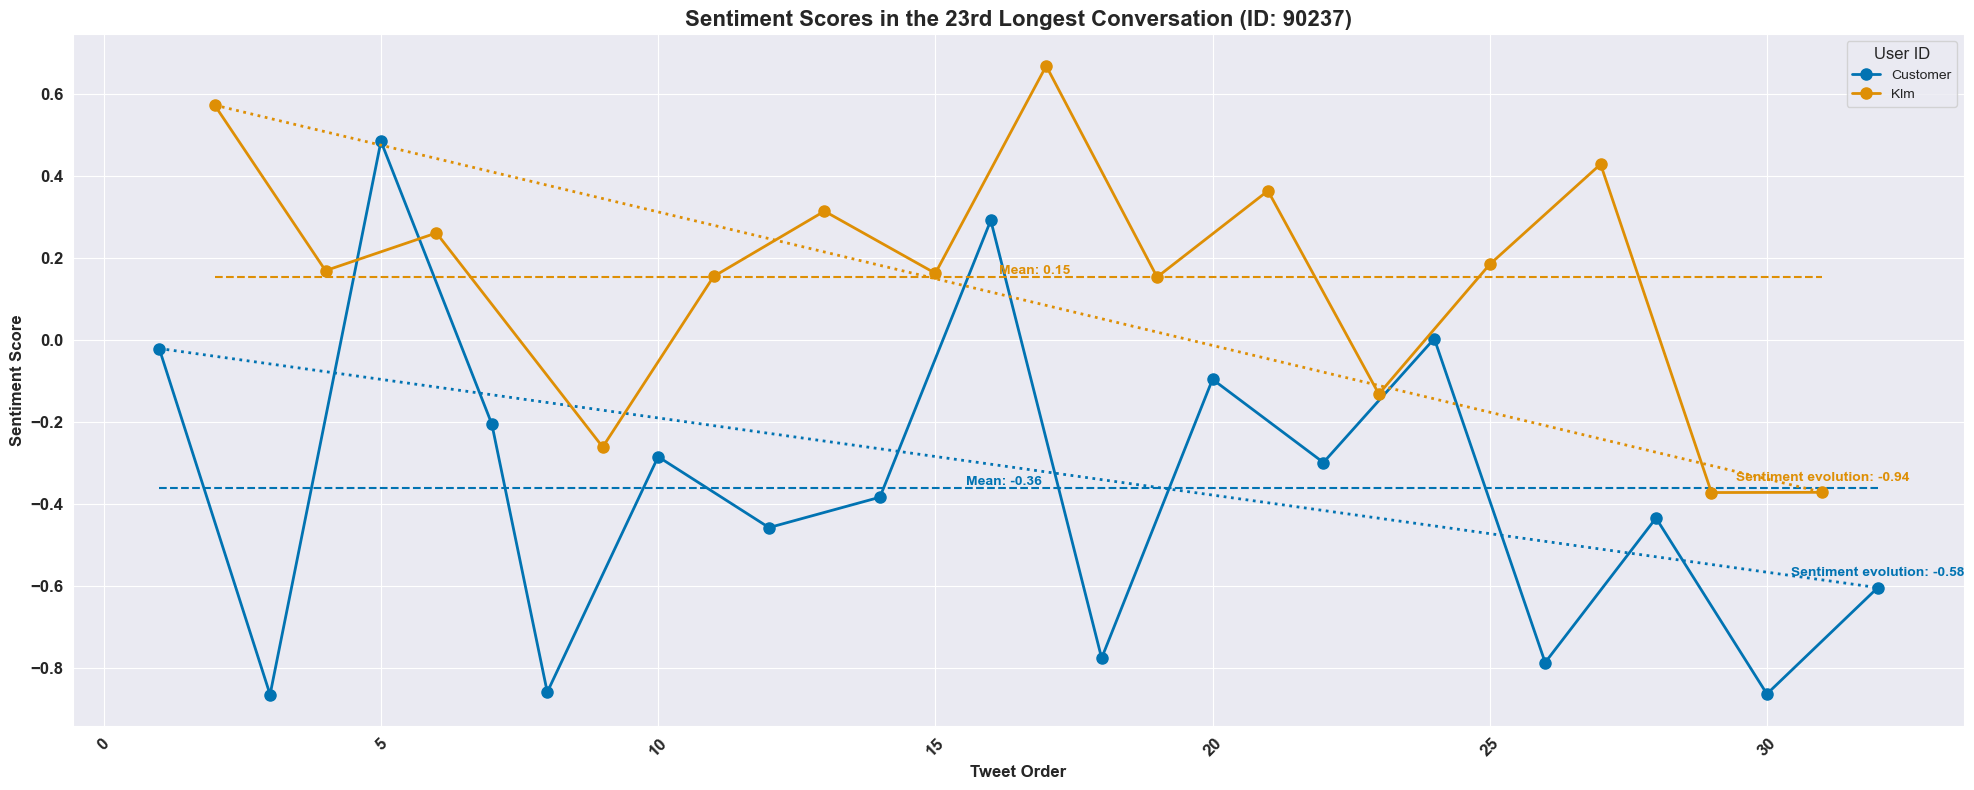

In [167]:
# Ensure tweet_creation_time and sentiment_score are in the correct format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Find and extract the nth longest conversation
nth = 23
conversation_lengths = df_reset['conversation_id'].value_counts()
nth_longest_conversation_id = conversation_lengths.index[nth - 1]
nth_longest_conversation_tweets = df_reset[df_reset['conversation_id'] == nth_longest_conversation_id].sort_values('tweet_order')

# Define color palette and map user_id to colors
palette = sns.color_palette("colorblind", n_colors=nth_longest_conversation_tweets['user_id'].nunique())
user_color_map = {user: palette[i] for i, user in enumerate(nth_longest_conversation_tweets['user_id'].unique())}
nth_longest_conversation_tweets['color'] = nth_longest_conversation_tweets['user_id'].map(user_color_map)

# Calculate average sentiment score for each user
avg_sentiment_scores = nth_longest_conversation_tweets.groupby('user_id')['sentiment_score'].mean()

# Plot the scatter plot with lines connecting dots for each user
plt.figure(figsize=(20, 8))
for user_id, group in nth_longest_conversation_tweets.groupby('user_id'):
    color = user_color_map[user_id]
    avg_sentiment = avg_sentiment_scores[user_id]
    first_last_diff = group['sentiment_score'].iloc[-1] - group['sentiment_score'].iloc[0]

    plt.plot(group['tweet_order'], group['sentiment_score'], color=color, label=COMPANY_ID_TO_NAME.get(user_id, "Customer"), marker='o', linestyle='-', linewidth=2, markersize=8)
    plt.hlines(avg_sentiment, xmin=group['tweet_order'].min(), xmax=group['tweet_order'].max(), colors=color, linestyles='dashed')
    plt.plot([group['tweet_order'].min(), group['tweet_order'].max()], [group['sentiment_score'].iloc[0], group['sentiment_score'].iloc[-1]], color=color, linestyle='dotted', linewidth=2)

    plt.text(group['tweet_order'].mean(), avg_sentiment, f'Mean: {avg_sentiment:.2f}', color=color, fontsize=10, weight='bold', ha='center', va='bottom')
    plt.text(group['tweet_order'].max(), group['sentiment_score'].iloc[-1] + 0.02, f'Sentiment evolution: {first_last_diff:.2f}', color=color, fontsize=10, weight='bold', ha='center', va='bottom')

plt.xlabel('Tweet Order', fontsize=12, weight='bold')
plt.ylabel('Sentiment Score', fontsize=12, weight='bold')
plt.title(f'Sentiment Scores in the {nth}rd Longest Conversation (ID: {nth_longest_conversation_id})', fontsize=16, weight='bold')
plt.xticks(rotation=45, fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.legend(title='User ID', fontsize=10, title_fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## Sentiment evolution

### Creating needed dataframes

In [168]:
# Group by 'Conversation' and 'user_id' to get the first and last sentiment scores
grouped = df_reset.groupby(['conversation_id', 'user_id'])

# Calculate the first and last sentiment scores
first_last_sentiments = grouped['sentiment_score'].agg(['first', 'last']).reset_index()

# Calculate the change in sentiment score
first_last_sentiments['change_in_sentiment'] = first_last_sentiments['last'] - first_last_sentiments['first']
# df_conversations_full = df_conversations_full.merge(first_last_sentiments[['Conversation', 'user_id', 'change_in_sentiment']], on=['Conversation', 'user_id'], how='left')

In [169]:
def categorize_sentiment_change(change):
    if change > 0:
        return 'Positive'
    elif change < 0:
        return 'Negative'
    else:
        return 'Neutral'

average_sentiment_per_user = df_reset.groupby(['conversation_id', 'user_id']).agg(
    tweets_number=("sentiment_score", "count"),
    average_sentiment=("sentiment_score", "mean"),
    min_sentiment=("sentiment_score", "min"),
    max_sentiment=("sentiment_score", "max"),
    first_tweet=("tweet_creation_time", "min")
).reset_index()

# Merge first_last_sentiments with average_sentiment_per_user
merged_df = pd.merge(average_sentiment_per_user, first_last_sentiments[['conversation_id', 'user_id', 'change_in_sentiment']],
                     on=['conversation_id', 'user_id'], how='left')
merged_df['sentiment_trend'] = merged_df['change_in_sentiment'].apply(categorize_sentiment_change)
merged_df["airline"] = merged_df["user_id"].map(COMPANY_ID_TO_NAME)

### Sentiment evolution per airline

posx and posy should be finite values
posx and posy should be finite values


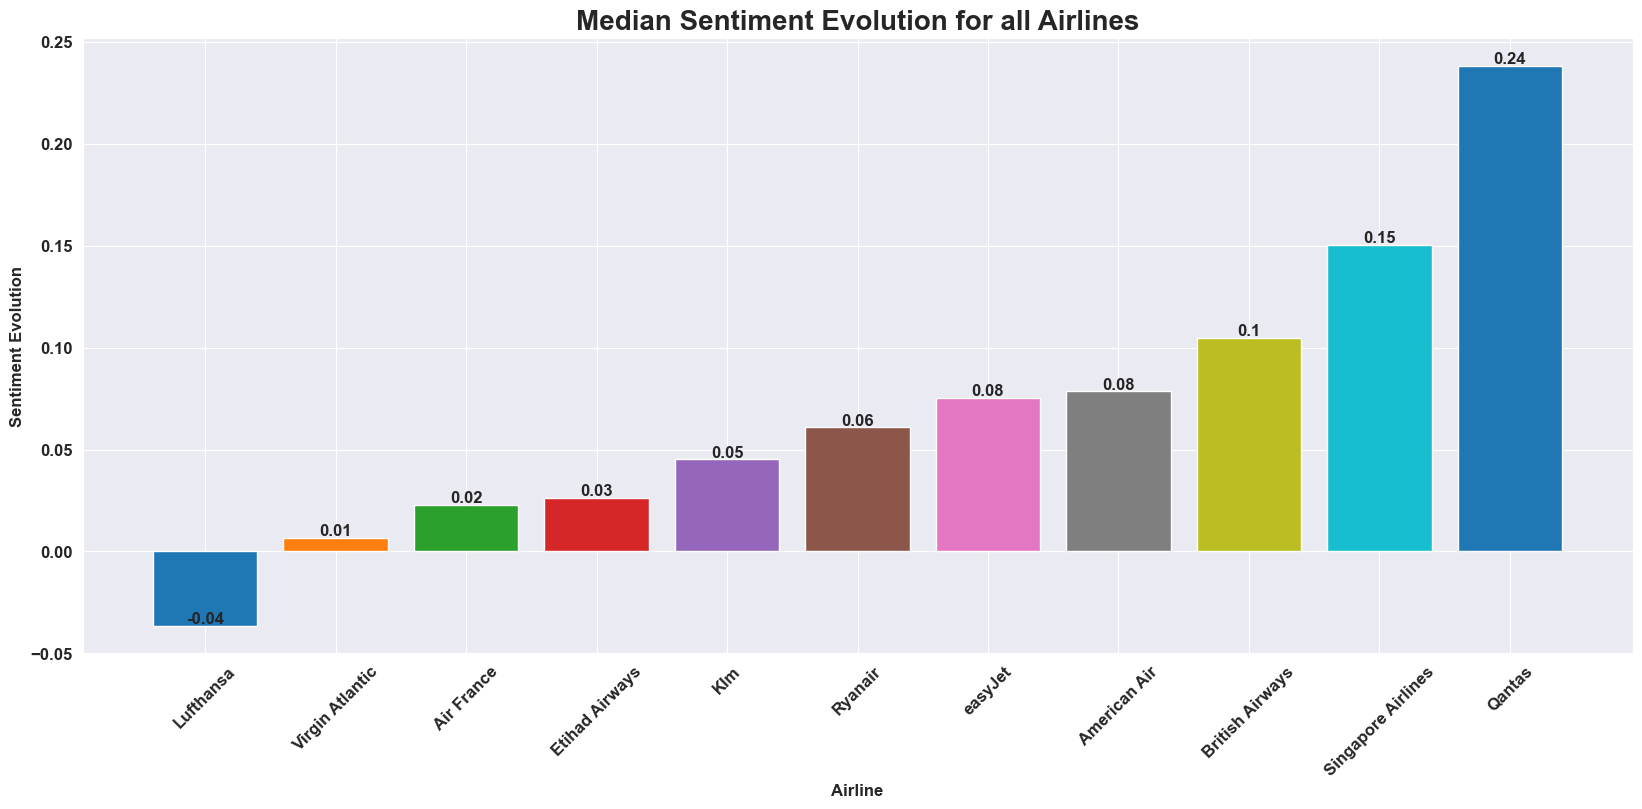

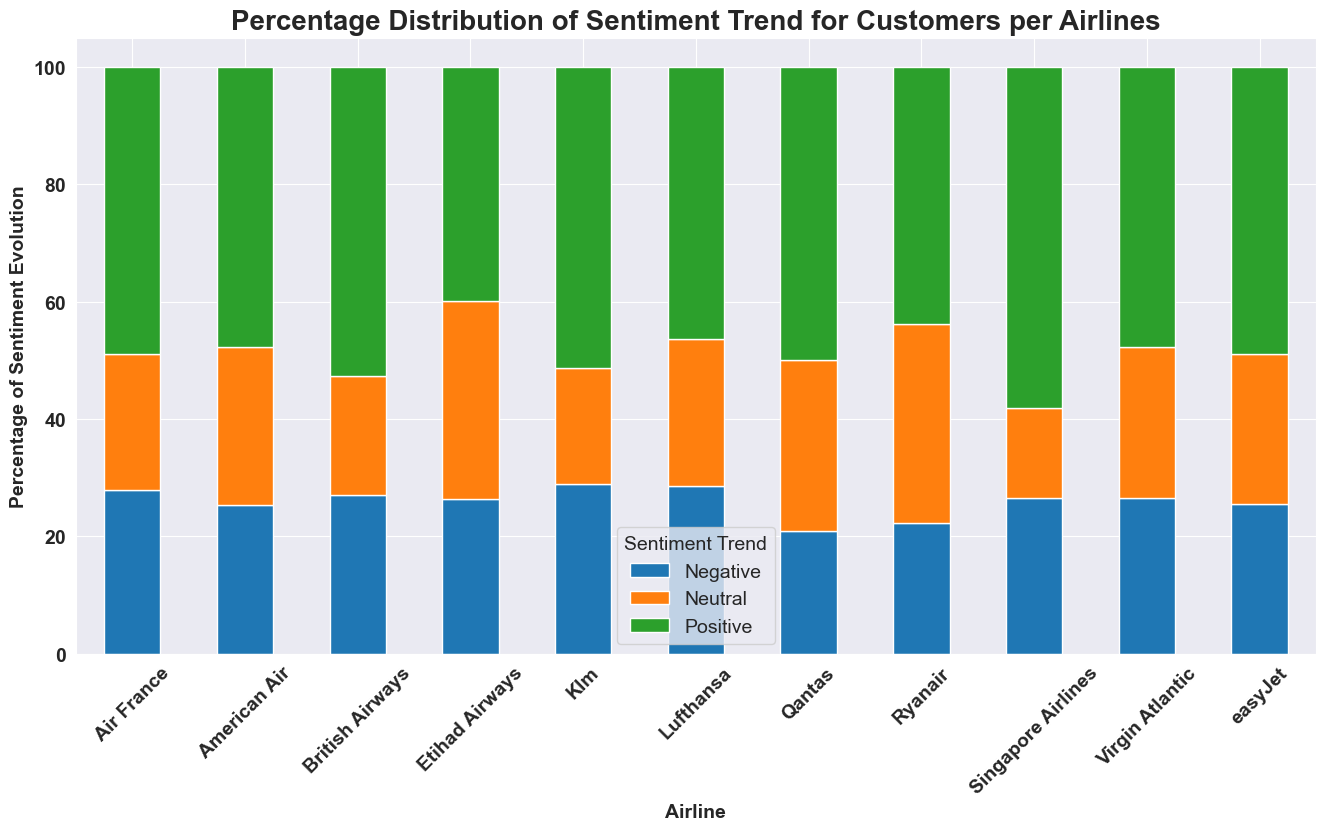

In [170]:
# Define a function to process sentiment evolution data
def process_sentiment_evolution(merged_df, min_tweets=2, exclude_airlines=False):
    if exclude_airlines:
        merged_df = merged_df[merged_df['airline'].isna()].copy()
    else:
        merged_df = merged_df.dropna(subset=['airline']).copy()

    conversation_airlines = merged_df.groupby('airline')['conversation_id'].unique()

    plot_data = []

    for airline, conversations in conversation_airlines.items():
        users_in_conversations = merged_df[merged_df['conversation_id'].isin(conversations)]
        if min_tweets:
            users_in_conversations = users_in_conversations[users_in_conversations['tweets_number'] >= min_tweets]
        users_in_conversations = users_in_conversations.query("change_in_sentiment != 0")
        avg_change = users_in_conversations['change_in_sentiment'].median()
        plot_data.append({'airline': airline, 'avg_change_in_sentiment': avg_change})

    plot_df = pd.DataFrame(plot_data).sort_values(by='avg_change_in_sentiment')

    return plot_df

# Define a function to plot the bar chart
def plot_bar_chart(data, x, y, title, xlabel, ylabel, label_offset=0.01, colors=None):
    plt.figure(figsize=(20, 8))
    bars = plt.bar(data[x], data[y], color=colors[:len(data[x])])
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    # Add data labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + label_offset, round(yval, 2), ha='center', fontsize=12, fontweight='bold')
    
    plt.show()

# Define a function to process sentiment trend data
def process_sentiment_trend(merged_df, min_tweets=2):
    filtered_df = merged_df[merged_df['tweets_number'] >= min_tweets]
    non_airline_df = filtered_df[filtered_df['airline'].isna()]

    airline_conversations = merged_df.dropna(subset=['airline'])
    conversation_airlines = airline_conversations.groupby('airline')['conversation_id'].unique()

    plot_data = []

    for airline, conversations in conversation_airlines.items():
        users_in_conversations = merged_df[merged_df['conversation_id'].isin(conversations)]
        users_in_conversations = users_in_conversations[users_in_conversations['conversation_id'].isin(non_airline_df['conversation_id'])]
        plot_data.extend(
            {
                'airline': airline,
                'change_in_sentiment': row['change_in_sentiment'],
                'sentiment_trend': row['sentiment_trend'],
            }
            for _, row in users_in_conversations.iterrows()
        )

    plot_df = pd.DataFrame(plot_data)
    sentiment_trend_counts = plot_df.groupby(['airline', 'sentiment_trend']).size().unstack()
    sentiment_trend_percentages = sentiment_trend_counts.div(sentiment_trend_counts.sum(axis=1), axis=0) * 100

    return sentiment_trend_percentages

# Define a function to plot the stacked bar chart
def plot_stacked_bar_chart(data, title, xlabel, ylabel, colors):
    plt.figure(figsize=(16, 8))
    data.loc[:, ['Negative', 'Neutral', 'Positive']].plot(kind='bar', stacked=True, color=colors[:3], ax=plt.gca())
    plt.xlabel(xlabel, fontsize=14, fontweight='bold')
    plt.ylabel(ylabel, fontsize=14, fontweight='bold')
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xticks(rotation=45, fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.legend(title='Sentiment Trend', fontsize=14, title_fontsize=14)
    plt.show()

# Define colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# 1st Plot: Median Sentiment Evolution for all Airlines
plot_df = process_sentiment_evolution(merged_df)
plot_bar_chart(plot_df, 'airline', 'avg_change_in_sentiment', 'Median Sentiment Evolution for all Airlines', 'Airline', 'Sentiment Evolution', label_offset=0.001, colors=colors)

# 2nd Plot: Percentage Distribution of Sentiment Trend for Customers per Airlines
sentiment_trend_percentages = process_sentiment_trend(merged_df)
plot_stacked_bar_chart(sentiment_trend_percentages, 'Percentage Distribution of Sentiment Trend for Customers per Airlines', 'Airline', 'Percentage of Sentiment Evolution', colors)

### Sentiment evolution per month

C:\Users\igor2\AppData\Local\Temp\ipykernel_66516\3479549634.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_customer_tweets['month'] = valid_customer_tweets['first_tweet'].dt.strftime('%B')
C:\Users\igor2\AppData\Local\Temp\ipykernel_66516\3479549634.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_customer_tweets_lufthansa['month'] = valid_customer_tweets_lufthansa['first_tweet'].dt.strftime('%B')
posx and posy should be finite values
posx and posy should be finite values
posx and pos

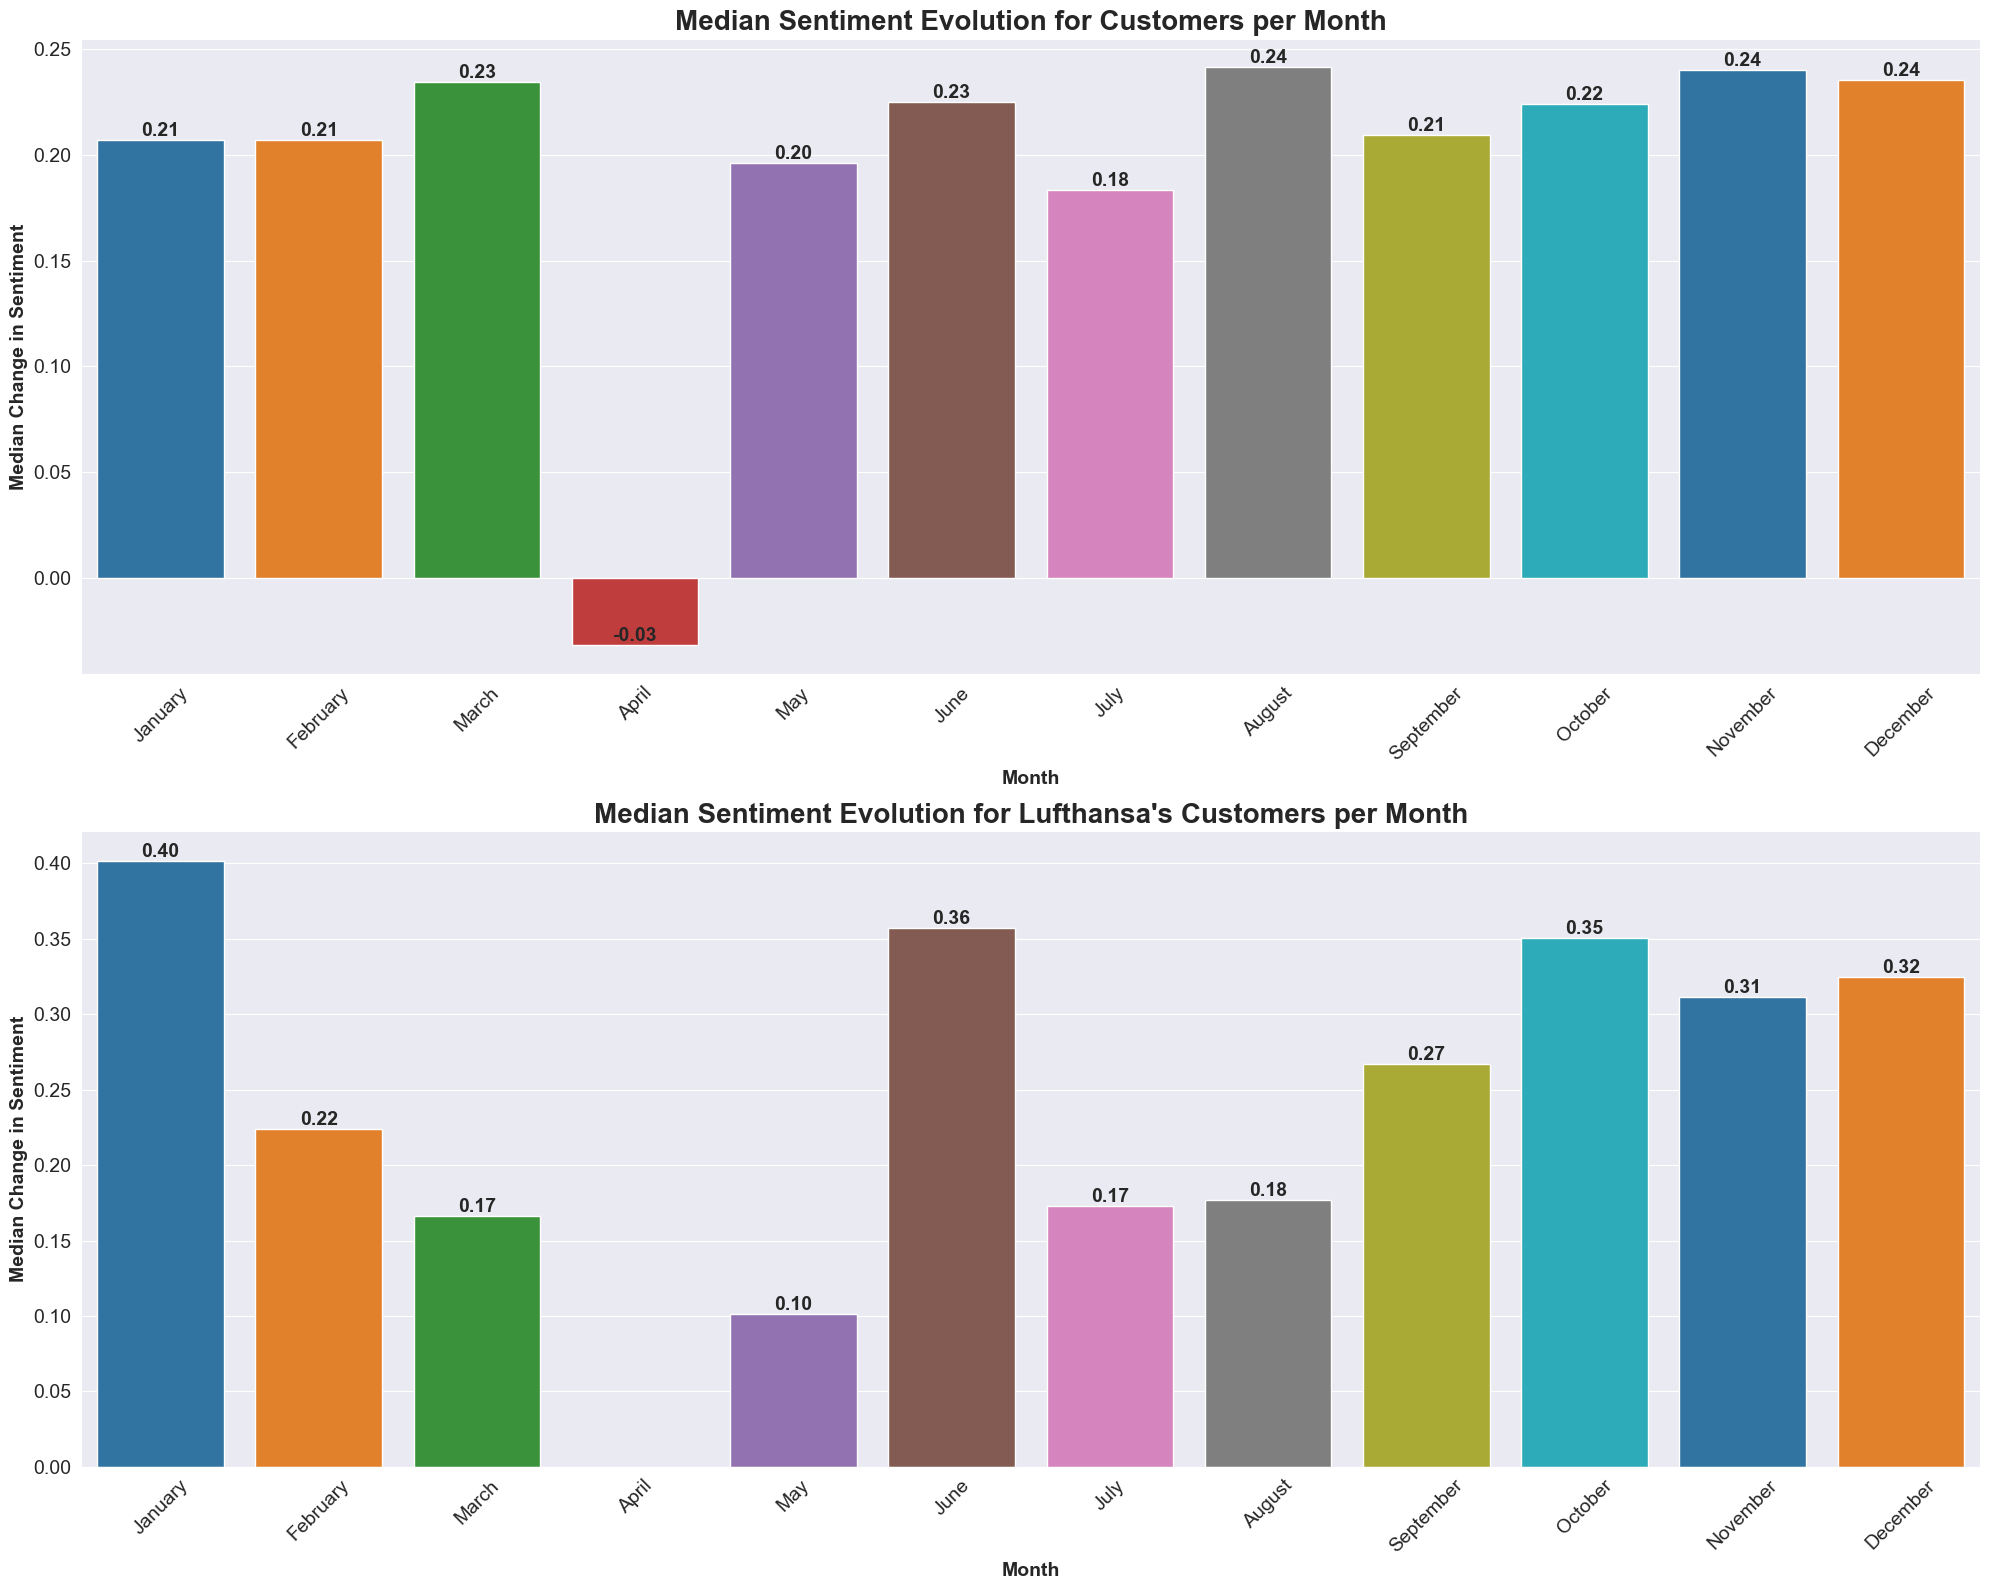

In [171]:
# Convert first_tweet to datetime if not already done
merged_df['first_tweet'] = pd.to_datetime(merged_df['first_tweet'])

# Identify customer tweets (tweets not from airlines)
customer_tweets = merged_df[merged_df['airline'].isna()]

# Filter conversations with more than 2 customer tweets
valid_customer_tweets = customer_tweets.query("tweets_number > 2")

# Extract the month from tweet creation time
valid_customer_tweets['month'] = valid_customer_tweets['first_tweet'].dt.strftime('%B')

# Calculate the median sentiment evolution per conversation
median_sentiment_evolution = valid_customer_tweets.groupby('conversation_id')['change_in_sentiment'].median().reset_index()

# Merge with the month information
valid_customer_tweets = valid_customer_tweets[['conversation_id', 'month']].drop_duplicates()
median_sentiment_evolution = median_sentiment_evolution.merge(valid_customer_tweets, on='conversation_id')

# Calculate the median sentiment change per month
median_sentiment_per_month = median_sentiment_evolution.groupby('month')['change_in_sentiment'].median().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Filter conversations involving Lufthansa
lufthansa_conversations = merged_df[merged_df['airline'] == 'Lufthansa']['conversation_id'].unique()

# Identify customer tweets in conversations where Lufthansa is participating
customer_tweets_lufthansa = merged_df[merged_df['conversation_id'].isin(lufthansa_conversations) & merged_df['airline'].isna()]

# Filter conversations with more than 2 customer tweets
valid_customer_tweets_lufthansa = customer_tweets_lufthansa.query("tweets_number > 2")

# Extract the month from tweet creation time
valid_customer_tweets_lufthansa['month'] = valid_customer_tweets_lufthansa['first_tweet'].dt.strftime('%B')

# Calculate the median sentiment evolution per conversation
median_sentiment_evolution_lufthansa = valid_customer_tweets_lufthansa.groupby('conversation_id')['change_in_sentiment'].median().reset_index()

# Merge with the month information
valid_customer_tweets_lufthansa = valid_customer_tweets_lufthansa[['conversation_id', 'month']].drop_duplicates()
median_sentiment_evolution_lufthansa = median_sentiment_evolution_lufthansa.merge(valid_customer_tweets_lufthansa, on='conversation_id')

# Calculate the median sentiment change per month
median_sentiment_per_month_lufthansa = median_sentiment_evolution_lufthansa.groupby('month')['change_in_sentiment'].median().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a color palette using mcolors
colors = list(mcolors.TABLEAU_COLORS.values())

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 16))

# First plot: Median Sentiment Evolutions of Customer Tweets per Month
sns.barplot(ax=axs[0], x=median_sentiment_per_month.index, y=median_sentiment_per_month.values, palette=colors)
axs[0].set_xlabel('Month', fontsize=14, fontweight='bold')
axs[0].set_ylabel('Median Change in Sentiment', fontsize=14, fontweight='bold')
axs[0].set_title('Median Sentiment Evolution for Customers per Month', fontsize=20, fontweight='bold')
axs[0].tick_params(axis='x', rotation=45, labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)

# Add numerical values on top of each bar
for index, value in enumerate(median_sentiment_per_month.values):
    axs[0].text(index, value, f'{value:.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Second plot: Median Sentiment Evolution of Customer Tweets in Conversations with Lufthansa per Month
sns.barplot(ax=axs[1], x=median_sentiment_per_month_lufthansa.index, y=median_sentiment_per_month_lufthansa.values, palette=colors)
axs[1].set_xlabel('Month', fontsize=14, fontweight='bold')
axs[1].set_ylabel('Median Change in Sentiment', fontsize=14, fontweight='bold')
axs[1].set_title("Median Sentiment Evolution for Lufthansa's Customers per Month", fontsize=20, fontweight='bold')
axs[1].tick_params(axis='x', rotation=45, labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)

# Add numerical values on top of each bar
for index, value in enumerate(median_sentiment_per_month_lufthansa.values):
    axs[1].text(index, value, f'{value:.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()

## Categories

### Sentiment scores per category

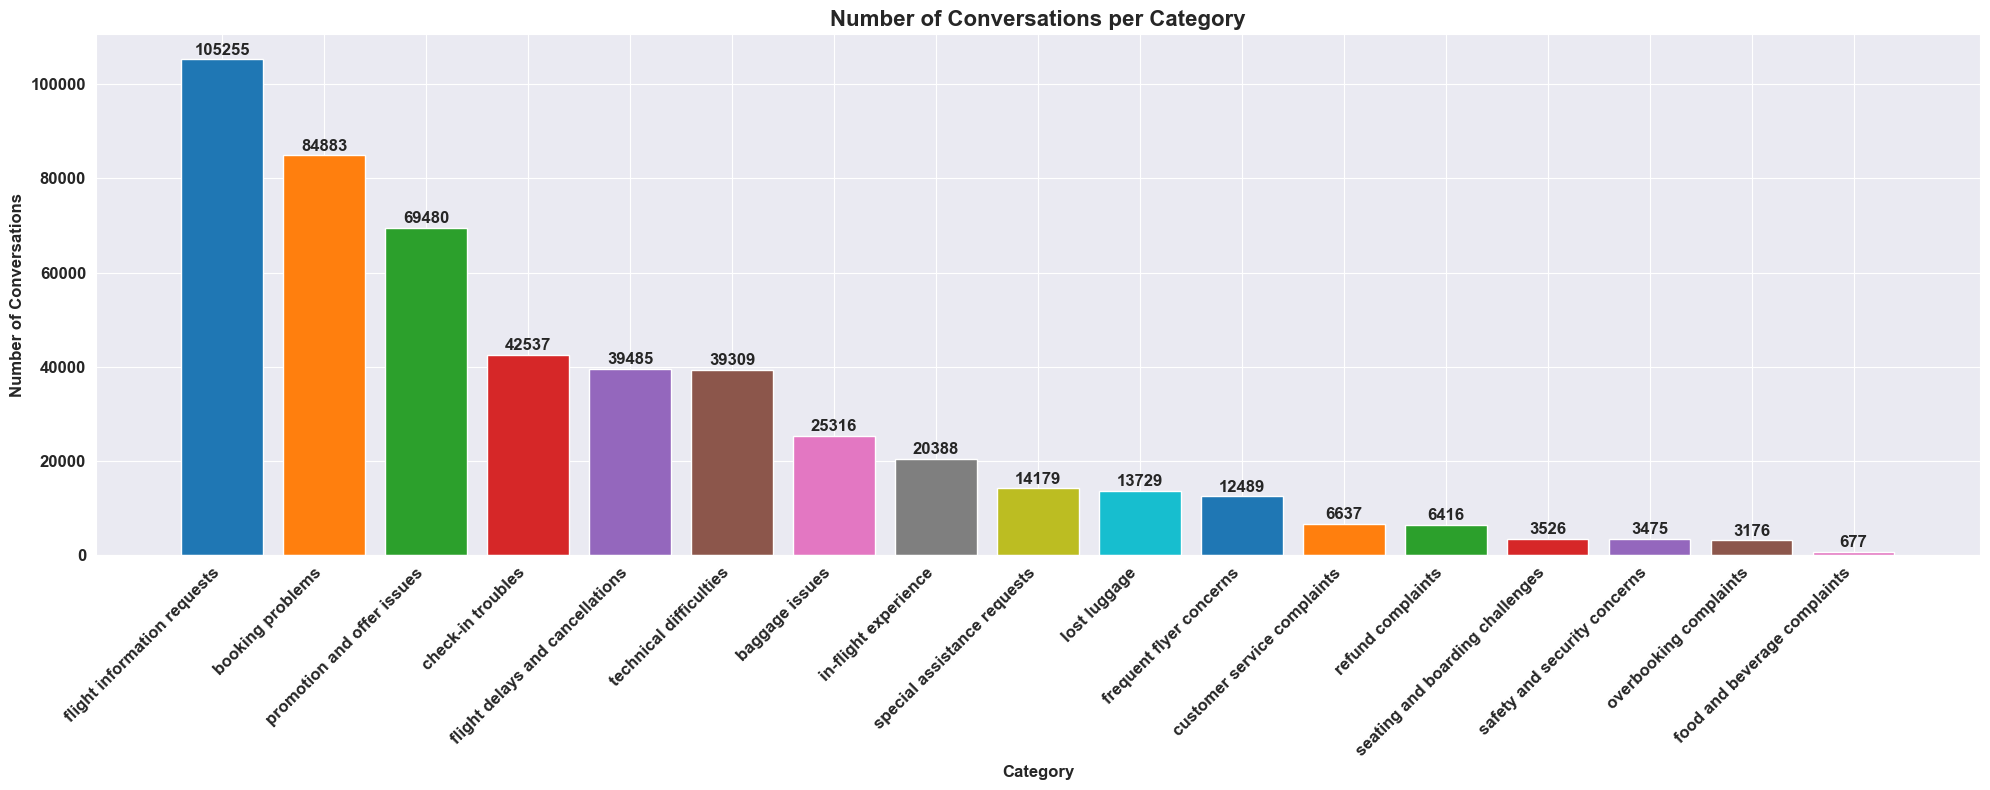

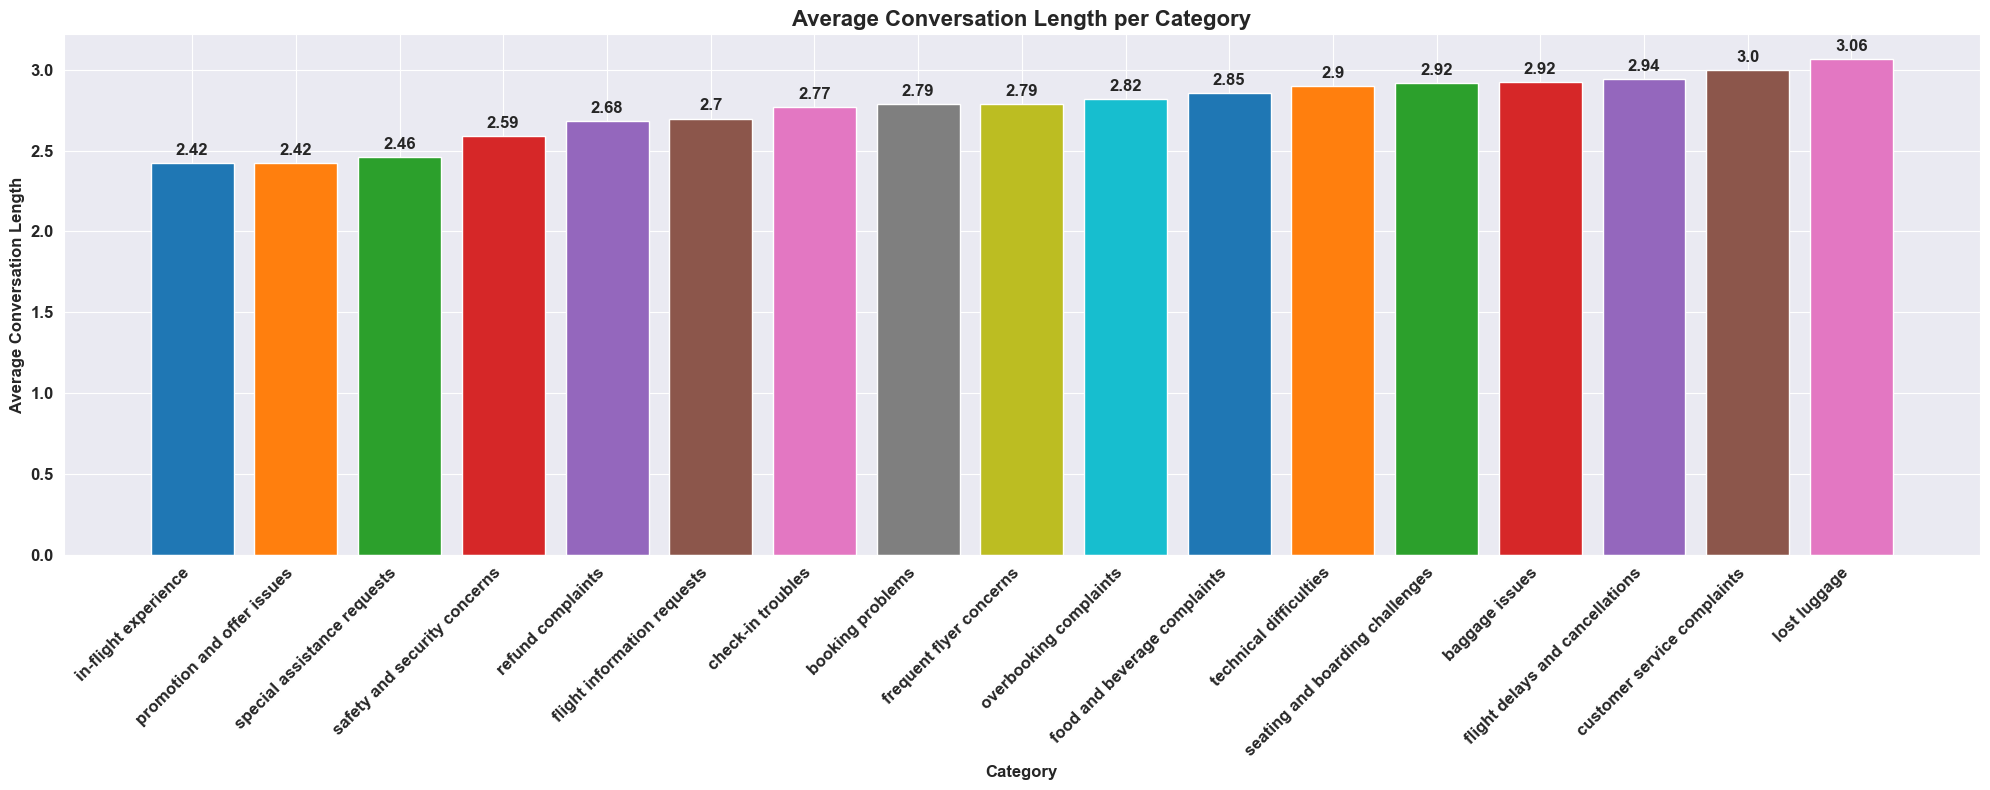

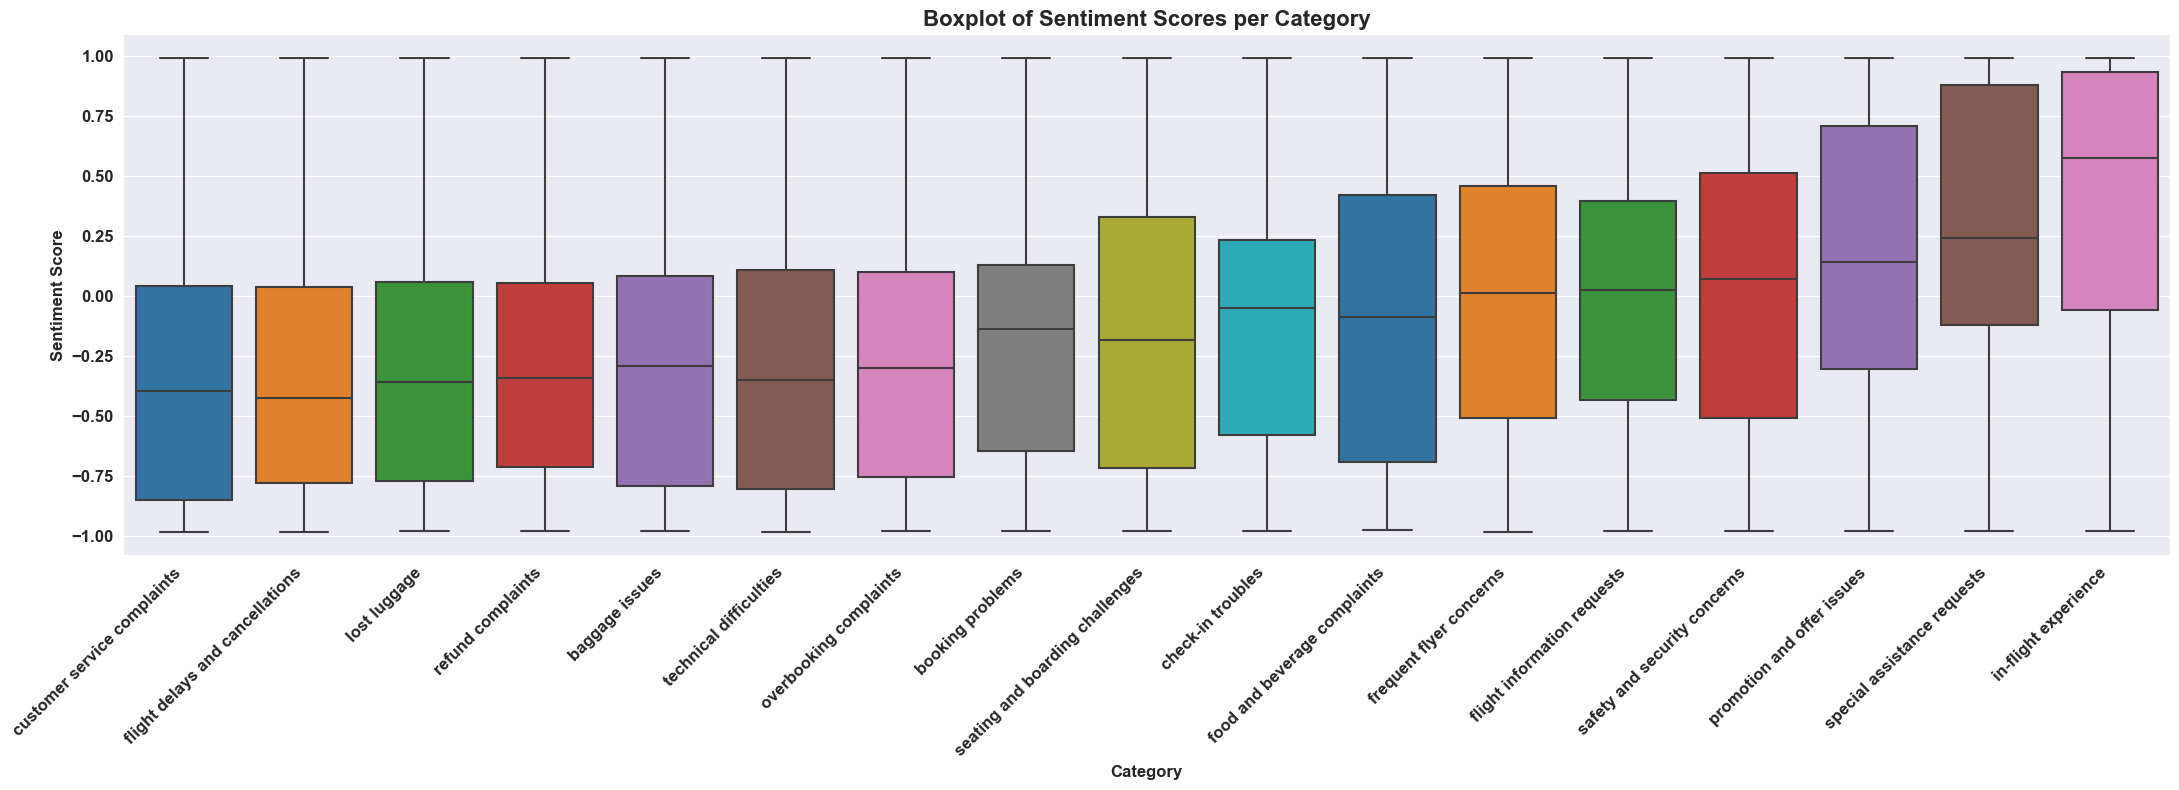

In [172]:
# Define a function to plot the bar chart
def plot_bar_chart(data, x, y, title, xlabel, ylabel, label_offset=0.01, colors=None):
    plt.figure(figsize=(20, 8))
    bars = plt.bar(data[x], data[y], color=colors[:len(data[x])])
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
    plt.yticks(fontsize=12, fontweight='bold')

    # Add data labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + label_offset, round(yval, 2) if isinstance(yval, float) else int(yval), ha='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Define a function to plot the box plot
def plot_box_plot(data, x, y, title, xlabel, ylabel, order, palette):
    plt.figure(figsize=(22, 8))
    sns.boxplot(x=x, y=y, data=data, order=order, palette=palette)
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Define colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# 1st Plot: Number of Conversations per Category
category_counts = df_categories['category'].value_counts()
plot_bar_chart(category_counts.reset_index(), 'index', 'category', 'Number of Conversations per Category', 'Category', 'Number of Conversations', label_offset=1000, colors=colors)

# 2nd Plot: Average Conversation Length per Category
conversation_lengths = df_reset.groupby('conversation_id').size().reset_index(name='conversation_length')
together = pd.merge(conversation_lengths, df_categories, on='conversation_id')
avg_conversation_length_per_category = together.groupby('category')['conversation_length'].mean().sort_values()
plot_bar_chart(avg_conversation_length_per_category.reset_index(), 'category', 'conversation_length', 'Average Conversation Length per Category', 'Category', 'Average Conversation Length', label_offset=0.05, colors=colors)

# 3rd Plot: Boxplot of Sentiment Scores per Category
to_plot = pd.merge(df_reset, df_categories, on='conversation_id')
average_sentiment_per_category = to_plot.groupby('category')['sentiment_score'].mean()
sorted_categories = average_sentiment_per_category.sort_values().index
plot_box_plot(to_plot, 'category', 'sentiment_score', 'Boxplot of Sentiment Scores per Category', 'Category', 'Sentiment Score', sorted_categories, colors[:len(sorted_categories)])

### Sentiment evolution per category

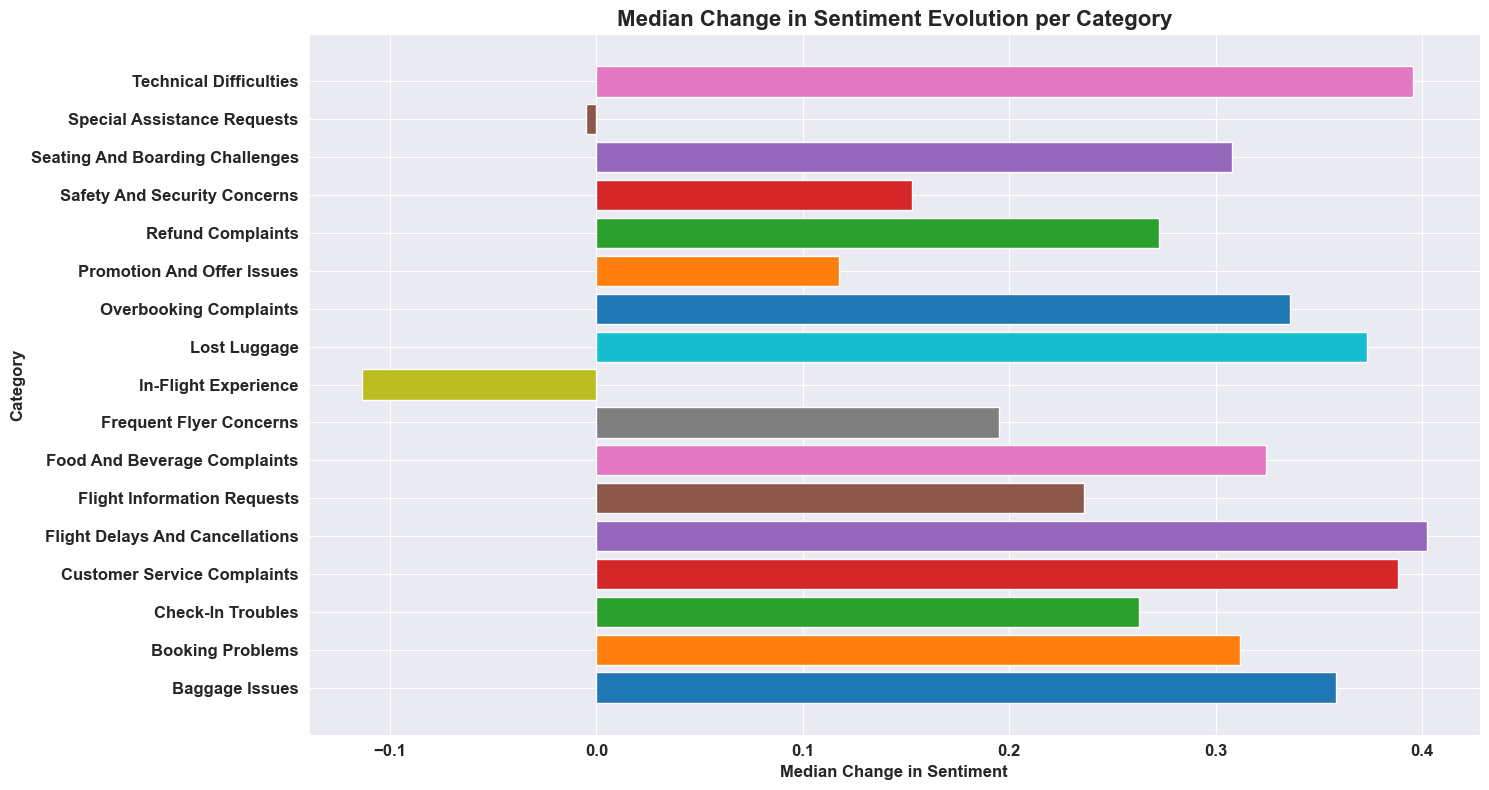

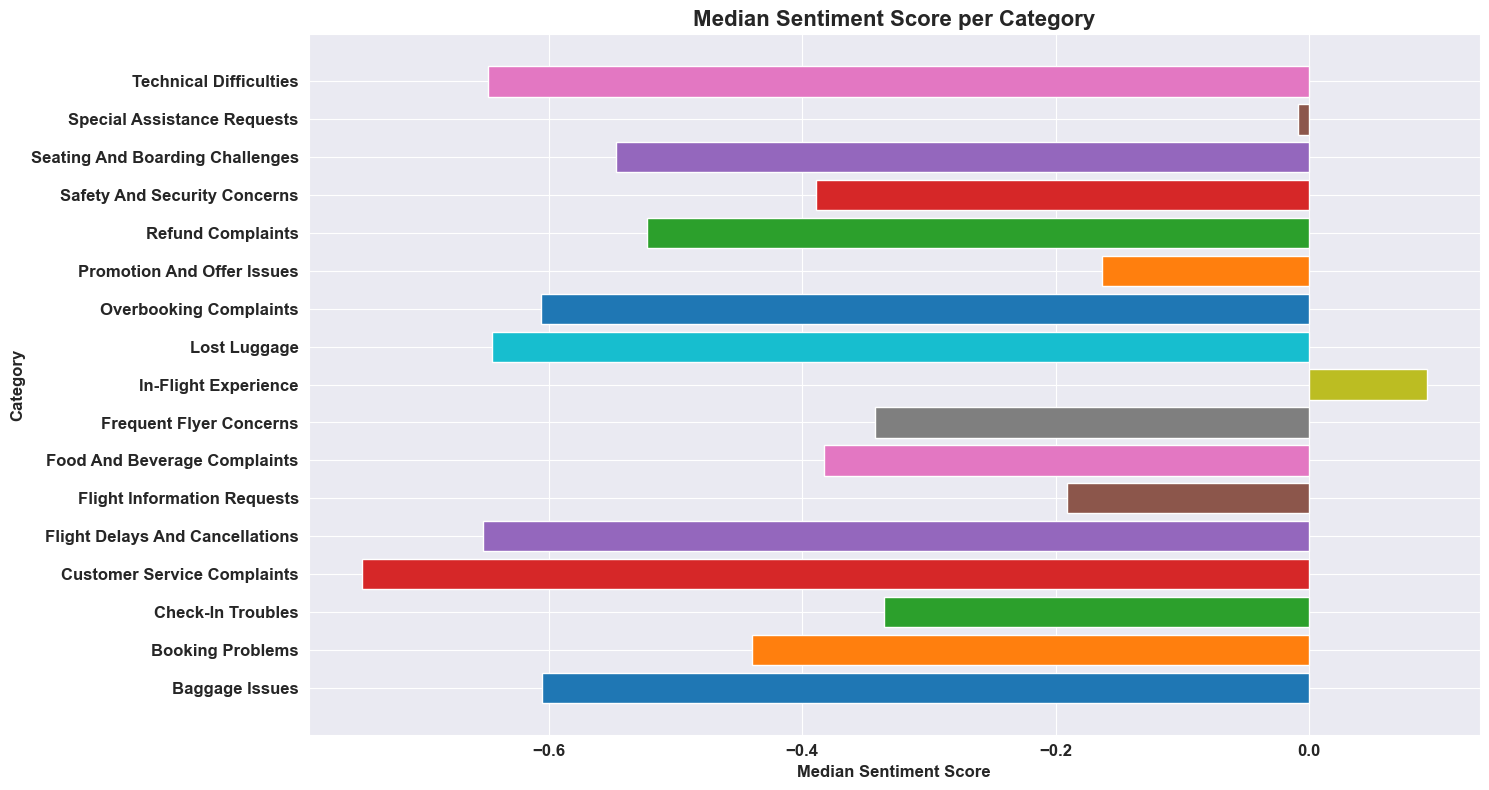

In [173]:
# Define a function to process conversation data
def process_conversation_data(df_categories, df_conversations, df_main, min_tweets=3):
    merged_check = pd.merge(df_categories, df_conversations, on='conversation_id')
    conversation_length = merged_check['conversation_id'].value_counts()
    valid_conversations = conversation_length[conversation_length >= min_tweets].index
    
    merged_data = pd.merge(df_categories, df_main, on='conversation_id')
    filtered_data = merged_data[merged_data['conversation_id'].isin(valid_conversations)]
    filtered_data = filtered_data[filtered_data['airline'].isna()]
    
    return filtered_data

# Define a function to plot the horizontal bar chart
def plot_horizontal_bar_chart(data, x, y, title, xlabel, ylabel, colors):
    plt.figure(figsize=(15, 8))
    plt.barh(data[y], data[x], color=colors[:len(data)])
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Define colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# 1st Plot: Median Change in Sentiment Evolution per Category
filtered_data = process_conversation_data(df_categories, df_conversations, merged_df)
median_sentiment_change = filtered_data.groupby('category')['change_in_sentiment'].mean().reset_index()
median_sentiment_change['category'] = median_sentiment_change['category'].str.title()
plot_horizontal_bar_chart(median_sentiment_change, 'change_in_sentiment', 'category', 'Median Change in Sentiment Evolution per Category', 'Median Change in Sentiment', 'Category', colors)

# 2nd Plot: Median Sentiment Score per Category
filtered_data = process_conversation_data(df_categories, df_conversations, df_reset)
median_sentiment_score = filtered_data.groupby('category')['sentiment_score'].median().reset_index()
median_sentiment_score['category'] = median_sentiment_score['category'].str.title()
plot_horizontal_bar_chart(median_sentiment_score, 'sentiment_score', 'category', 'Median Sentiment Score per Category', 'Median Sentiment Score', 'Category', colors)

In [174]:
# Counting the percentage of conversations with a sentiment greater than 0.2

In [175]:
filtered_df = merged_df[merged_df['tweets_number'] >= 2]

# Exclude conversations associated with airlines
non_airline_df = filtered_df[filtered_df['airline'].isna()]

# Filter conversations with a change in sentiment greater than 0.2
high_sentiment_change_df = non_airline_df[non_airline_df['change_in_sentiment'].abs() >= 0.2]

# Calculate the total number of conversations with at least 2 tweets
total_conversations = len(filtered_df)

# Calculate the number of conversations with a change in sentiment greater than 0.2
high_sentiment_change_conversations = len(high_sentiment_change_df)

# Calculate the percentage
percentage = (high_sentiment_change_conversations / total_conversations) * 100

percentage

43.600360623503356